# Final Project in Text Analysis and Natural Language Processing

### Title: Predicting financial risk using NLP, a sentiment and entity based approach

#### Table of contents:


<a href='#web_scrape'>1. Webscraping the data from the Google News </a><br>
    
<a href='#data_cleaning'>2. Text Cleaning & Deduplication</a>

<a href='#text_pre'>3. Text Preprocessing</a>	

<a href='#sent_ana'>4. Sentiment Analysis with VADER </a>

<a href='#fin_ana'>5. Sentiment Analysis with FinBERT </a>

<a href='#Sen_Comp'>6. Comparison of Sentiments: VADER vs FinBert </a>

<a href='#name_reco'>7. Named Entity Recognition (NER) </a>

<a href='#stock_corr'>8. Stock Price Data Collection and Sentiment Correlation </a>

<a href='#top_mod'>9. Topic Modeling for News Themes Driving Financial Risk </a>

<a href='#risk_score'>10. Risk Scoring Model for Financial Risk Prediction </a>

<a href='#risk_eva'>11. Evaluating the Risk Scoring Model </a>




### Importing the needed libraries

Here we are importing the libraries that I will be needing for the further analysis:

In [85]:
#Importing libraries to scrap
#from serpapi import GoogleSearch

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import re

# Importing libraries for text preprocossing 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Importing library for VADAR Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#importin libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Importing library for FinBERT Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
from tqdm import tqdm
import requests

## Importing library for NER
import spacy
from collections import Counter

# In order to ignore the warnings, not show the warnings in the code output
import warnings
warnings.filterwarnings("ignore")

# Imporint library for Topic Modeling
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models import LdaModel

import yfinance as yf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score




## Webscraping the data from the Independent newspaper <a id='web_scrape'></a>

### Web Scraping Financial News from Google News

To build a dataset of recent financial news, we used the SerpAPI wrapper to scrape Google News results for four major publicly traded companies: **Apple**, **Tesla**, **Nvidia**, and **Amazon**. Our objective was to collect high-quality news headlines and descriptions from the past 90 days.

Each request targeted 100 articles per page using the query format `"Company stock"`, with a cap of 600 articles per company. Using robust relative date parsing and filtering logic, we ensured that only articles within the desired date range were retained.

The final dataset includes:
- Company name
- News headline
- Snippet
- URL link
- Source publication
- Published date


In [ ]:
# Step 1: Your SerpAPI Key
API_KEY = "---"

# Step 2: Parse Relative/Absolute Dates
def parse_relative_date(text):
    today = datetime.today()
    try:
        if re.search(r"\w{3,} \d{1,2}, \d{4}", text):  # e.g. Apr 4, 2025
            return datetime.strptime(text, "%b %d, %Y")
        elif "day" in text:
            days = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(days=days)
        elif "hour" in text:
            hours = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(hours=hours)
        elif "week" in text:
            weeks = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(weeks=weeks)
        elif "month" in text:
            months = int(re.search(r"(\d+)", text).group(1))
            return today - timedelta(days=30 * months)
        else:
            return None
    except:
        return None

# Step 3: Scraper Function
def scrape_serpapi_news(company, target_articles=600):
    print(f"Scraping {company}...")
    results = []
    page = 0
    collected = 0
    today = datetime.today()
    ninety_days_ago = today - timedelta(days=90)

    while collected < target_articles:
        params = {
            "engine": "google",
            "q": f"{company} stock",
            "tbm": "nws",
            "api_key": API_KEY,
            "num": 100,
            "start": page * 100,
            "tbs": "cdr:1,cd_min:1/14/2024,cd_max:4/14/2025"
        }

        search = GoogleSearch(params)
        response = search.get_dict()
        news_results = response.get("news_results", [])

        if not news_results:
            print(f"No more news results found at page {page} for {company}")
            break

        for article in news_results:
            pub_date_raw = article.get("date")
            parsed_date = parse_relative_date(pub_date_raw)

            if parsed_date and parsed_date >= ninety_days_ago:
                results.append({
                    "company": company,
                    "title": article.get("title"),
                    "link": article.get("link"),
                    "snippet": article.get("snippet"),
                    "source": article.get("source"),
                    "published": parsed_date.strftime("%m/%d/%Y")
                })

        collected = len(results)
        page += 1
        time.sleep(1)

    print(f"Collected {len(results)} valid articles for {company}")
    return pd.DataFrame(results[:target_articles])

# Step 4: List of Companies
companies = ["Apple", "Tesla", "Nvidia", "Amazon"]

# Step 5: Scrape & Save
all_dfs = []
for company in companies:
    df = scrape_serpapi_news(company, target_articles=600)
    all_dfs.append(df)

final_df = pd.concat(all_dfs, ignore_index=True)

### Reading the data

For confidentiality purposes, i have hidden my API and have uploaded and read the data below:

In [45]:
final_df = pd.read_csv("C:\\Users\\Mustafa Ansari\\Downloads\\Scrapped Google News.csv")

In [46]:
final_df.head()

company                                              title  \
0   Apple              Where Will Apple Stock Be In 5 Years?   
1   Apple    Apple Joins AI Data Center Race After Siri Mess   
2   Apple  How Bad Could Sustained Tariffs Be for Apple S...   
3   Apple  Analysts revisit Apple stock price targets as ...   
4   Apple  Watch These Apple Stock Price Levels Amid Tari...   

                                                link  \
0  https://www.forbes.com/sites/investor-hub/arti...   
1  https://www.investors.com/news/technology/appl...   
2  https://www.morningstar.com/stocks/how-bad-cou...   
3  https://www.thestreet.com/investing/analysts-r...   
4  https://www.investopedia.com/watch-these-apple...   

                                             snippet  \
0  The shares currently trade approximately 12% b...   
1  Apple is in the process of placing orders for ...   
2  If tariffs persist, Apple's profit margins cou...   
3  Wedbush analyst Dan Ives, a committed Apple bu...   
4  Apple shares gained ground Wednesday after los...   

                      source   published  
0                     Forbes  03/15/2025  
1  Investor's Business Daily  03/24/2025  
2                Morningstar  04/09/2025  
3                  TheStreet  03/24/2025  
4               Investopedia  04/09/2025

### Checking Missing Values 

In [47]:
print(final_df.isnull().sum())  # check for missing values
print(f"Duplicate titles: {final_df.duplicated(subset='title').sum()}")


company      0
title        0
link         0
snippet      0
source       0
published    0
dtype: int64
Duplicate titles: 213


## Text Cleaning & Deduplication <a id='data_cleaning'></a>

In this step, i have firstly combined title and snippet into a single column: text then dropped exact duplicates of combined text and dropped nulls and whitespace-only entries. Finally i have reset index for tidy output.

In [48]:
# Original Data
original_count = len(final_df)
df = final_df.copy()

# STEP 1: Combine title + snippet
df["text"] = df["title"].fillna("") + ". " + df["snippet"].fillna("")

# STEP 2: Remove short/empty text
df["text"] = df["text"].str.strip()
before_empty_filter = len(df)
df = df[df["text"].str.len() > 10]
after_empty_filter = len(df)
empty_dropped = before_empty_filter - after_empty_filter

# STEP 3: Remove exact duplicates
before_dedup = len(df)
df = df.drop_duplicates(subset=["text"])
after_dedup = len(df)
duplicates_dropped = before_dedup - after_dedup

# STEP 4: Reset index
df = df.reset_index(drop=True)



In [49]:
# Summary
print("Cleaning Summary:")
print(f"• Original articles: {original_count}")
print(f"• Removed short/empty text: {empty_dropped}")
print(f"• Removed duplicates: {duplicates_dropped}")
print(f" Final cleaned articles: {len(df)}")

Cleaning Summary:
• Original articles: 1929
• Removed short/empty text: 0
• Removed duplicates: 146
 Final cleaned articles: 1783


In [50]:
df.head()

company                                              title  \
0   Apple              Where Will Apple Stock Be In 5 Years?   
1   Apple    Apple Joins AI Data Center Race After Siri Mess   
2   Apple  How Bad Could Sustained Tariffs Be for Apple S...   
3   Apple  Analysts revisit Apple stock price targets as ...   
4   Apple  Watch These Apple Stock Price Levels Amid Tari...   

                                                link  \
0  https://www.forbes.com/sites/investor-hub/arti...   
1  https://www.investors.com/news/technology/appl...   
2  https://www.morningstar.com/stocks/how-bad-cou...   
3  https://www.thestreet.com/investing/analysts-r...   
4  https://www.investopedia.com/watch-these-apple...   

                                             snippet  \
0  The shares currently trade approximately 12% b...   
1  Apple is in the process of placing orders for ...   
2  If tariffs persist, Apple's profit margins cou...   
3  Wedbush analyst Dan Ives, a committed Apple bu...   
4  Apple shares gained ground Wednesday after los...   

                      source   published  \
0                     Forbes  03/15/2025   
1  Investor's Business Daily  03/24/2025   
2                Morningstar  04/09/2025   
3                  TheStreet  03/24/2025   
4               Investopedia  04/09/2025   

                                                text  
0  Where Will Apple Stock Be In 5 Years?. The sha...  
1  Apple Joins AI Data Center Race After Siri Mes...  
2  How Bad Could Sustained Tariffs Be for Apple S...  
3  Analysts revisit Apple stock price targets as ...  
4  Watch These Apple Stock Price Levels Amid Tari...

## Text Preprocessing <a id='text_pre'></a>

**In this section the following text preprocessing steps have been implemented:**

1.  Lowercasing

2. Remove punctuation & special characters

3.  Remove digits and extra whitespace

4. Tokenize text (split into words)

5. Remove stopwords (e.g., "the", "is", "of")

6. Lemmatize words (e.g., “running” → “run”)


In [51]:
# Download NLTK resources (one-time)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Setup
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs, special characters, digits
    text = re.sub(r"http\S+|www\S+|[^a-z\s]", " ", text)

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Return processed text as space-separated string
    return " ".join(tokens)

# Apply to all texts
df["text_clean"] = df["text"].apply(preprocess_text)

# Preview
print(df[["company", "text_clean"]].sample(3))



[nltk_data] Downloading package punkt to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Mustafa
[nltk_data]     Ansari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     company                                         text_clean
634    Tesla  tesla worst sale year ever stock great run als...
1121  Nvidia  tariff really hurt nvidia stock see trump admi...
1254  Nvidia  nvidia stock fall two question dog investor re...


### Text Preprocessing

We performed several standard NLP preprocessing steps on the cleaned news articles:

1. **Lowercasing** — to unify word forms.
2. **Removing special characters, digits, and URLs** — to reduce noise.
3. **Tokenization** — splitting sentences into words using `nltk.word_tokenize()`.
4. **Stopword removal** — removing common, non-informative words using NLTK's English stopword list.
5. **Lemmatization** — converting words to their base forms using `WordNetLemmatizer`.



## Sentiment Analysis with VADER <a id='sent_ana'></a>

To begin the sentiment analysis, I use **VADER (Valence Aware Dictionary and sEntiment Reasoner)** - a fast and interpretable rule-based model built specifically for short text like headlines or tweets.

VADER is ideal for our dataset because:
- It works well on finance-related headlines and snippets
- It provides a **compound score** between -1 (negative) and +1 (positive)
- It also returns **positive, neutral, and negative** proportions

I'll compute the compound score and assign a sentiment label:
- **Positive** if score ≥ 0.05  
- **Negative** if score ≤ -0.05  
- **Neutral** otherwise

In [59]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score and label
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        label = 'positive'
    elif compound <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return pd.Series([compound, label])

# Apply to cleaned text
df[["vader_score", "vader_label"]] = df["text_clean"].apply(get_vader_sentiment)

# Preview
df[["company", "text_clean", "vader_score", "vader_label"]].sample(5)


company                                         text_clean  vader_score  \
1516  Amazon  tariff bringing amazon stock investor buy dip ...       0.3182   
1760  Amazon  smart portfolio llc sell share amazon com inc ...       0.8934   
321    Apple  apple may cancel iphone model deal tariff morg...      -0.4767   
1733  Amazon  amazon amzn aws revenue hit get triple digit g...       0.4019   
26     Apple  apple stock tumble tariff shock hardest hit ma...       0.0258   

     vader_label  
1516    positive  
1760    positive  
321     negative  
1733    positive  
26       neutral

**Each row now includes two new columns:**

- `vader_score`: A numeric sentiment value between -1 (very negative) and +1 (very positive)
- `vader_label`: A human-readable classification based on the score:

  - **Positive** if score ≥ 0.05
  - **Negative** if score ≤ -0.05
  - **Neutral** if in between

For example:
- *A Tesla article with a score of **-0.63** is labeled **negative**, reflecting bearish tone.*
- *An Amazon headline scored **0.20** is labeled **positive**, indicating optimistic sentiment.*

This helps us quantify how financial news articles emotionally frame events and companies.


### VADER Sentiment Distribution by Company (Count & Percentage)

To get an overview of sentiment trends, we group the sentiment labels by company and count how many headlines were classified as **positive**, **neutral**, or **negative**.



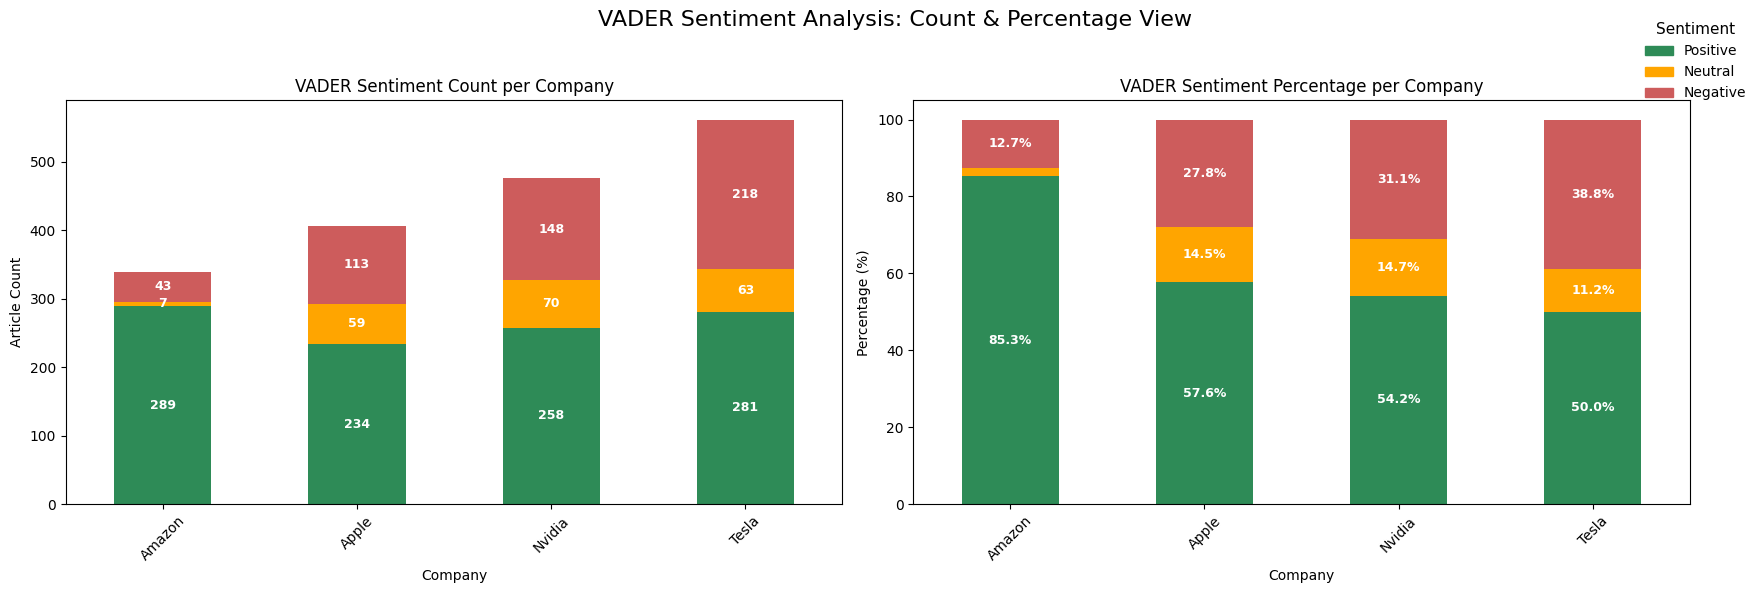

In [53]:

# Group sentiment counts and compute percentage
company_sent = df.groupby(["company", "vader_label"]).size().unstack().fillna(0)
sentiment_order = ["positive", "neutral", "negative"]
company_sent = company_sent[sentiment_order]
company_sent_pct = company_sent.div(company_sent.sum(axis=1), axis=0) * 100

# Color palette
custom_colors = {
    "positive": "#2E8B57",   # Green
    "neutral": "#FFA500",    # Orange
    "negative": "#CD5C5C"    # Red
}

# Set up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Count
company_sent.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    color=[custom_colors[s] for s in sentiment_order],
    legend=False
)
axes[0].set_title("VADER Sentiment Count per Company")
axes[0].set_xlabel("Company")
axes[0].set_ylabel("Article Count")
axes[0].tick_params(axis='x', rotation=45)

# Label bars with counts
x_ticks = axes[0].get_xticks()
for i, company in enumerate(company_sent.index):
    bottom = 0
    for sentiment in sentiment_order:
        count = company_sent.loc[company, sentiment]
        if count > 0:
            axes[0].text(
                x=x_ticks[i],
                y=bottom + count / 2,
                s=int(count),
                ha='center',
                va='center',
                fontsize=9,
                color='white',
                fontweight='bold'
            )
            bottom += count

# Percentage
company_sent_pct.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    color=[custom_colors[s] for s in sentiment_order],
    legend=False
)
axes[1].set_title("VADER Sentiment Percentage per Company")
axes[1].set_xlabel("Company")
axes[1].set_ylabel("Percentage (%)")
axes[1].tick_params(axis='x', rotation=45)

# Label bars with percentage
x_ticks_pct = axes[1].get_xticks()
for i, company in enumerate(company_sent_pct.index):
    bottom = 0
    for sentiment in sentiment_order:
        percent = company_sent_pct.loc[company, sentiment]
        if percent >= 5:
            axes[1].text(
                x=x_ticks_pct[i],
                y=bottom + percent / 2,
                s=f"{percent:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white',
                fontweight='bold'
            )
        bottom += percent

# legend
legend_handles = [Patch(color=custom_colors[s], label=s.capitalize()) for s in sentiment_order]
fig.legend(
    handles=legend_handles,
    title="Sentiment",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

# layout
plt.suptitle("VADER Sentiment Analysis: Count & Percentage View", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


**VADER Sentiment Summary**

The visualizations highlight both the volume and tone of news coverage across companies:

- **Tesla** leads in article count and shows a significant share of **negative sentiment** (218 articles, 38.8%), indicating high media attention with controversy.
- **Amazon** has fewer articles overall but dominates in **positive sentiment** (289 articles, 85.3%), reflecting favorable media tone.
- **Apple** and **Nvidia** receive balanced coverage with a moderate mix of sentiments. Nvidia shows slightly higher negativity (31.1%) than Apple (27.8%).


This helps us understand how media tone varies between companies in the last 90 days and sets a baseline for comparing results with FinBERT next.


## TF-IDF Bigram Word Clouds by VADER Sentiment 

To explore how language differs across sentiment classes, I am generating word clouds for each sentiment label (positive, neutral, negative) using both VADAR results.

This helps us visualize the dominant vocabulary associated with different market tones and provides clues about how risk-related vs. opportunity-related terms are distributed across the financial headlines.

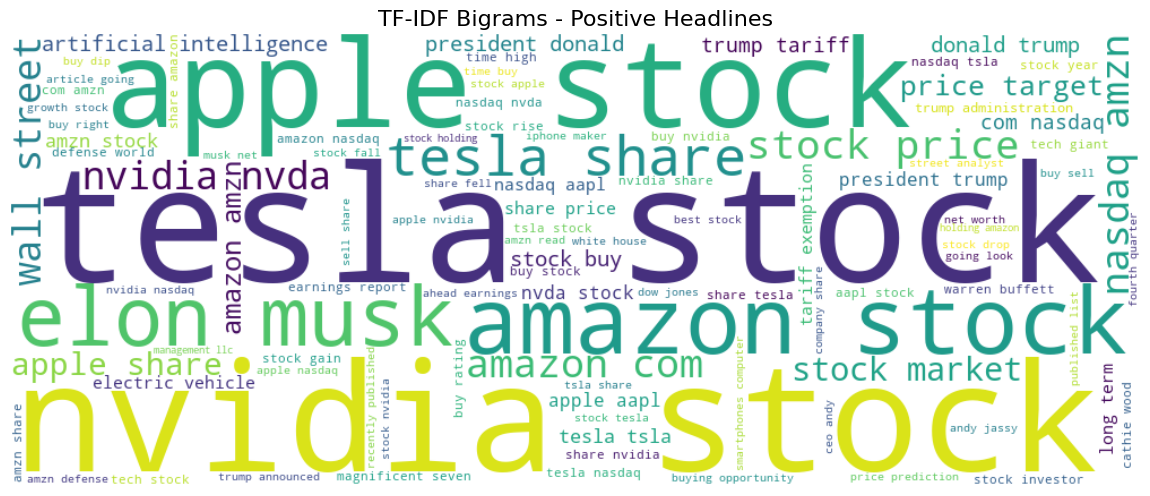

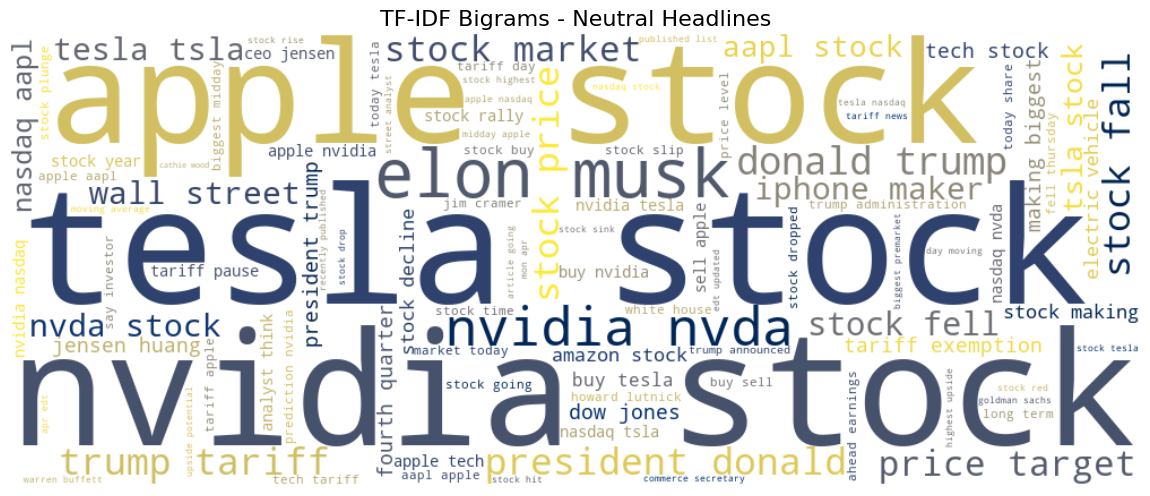

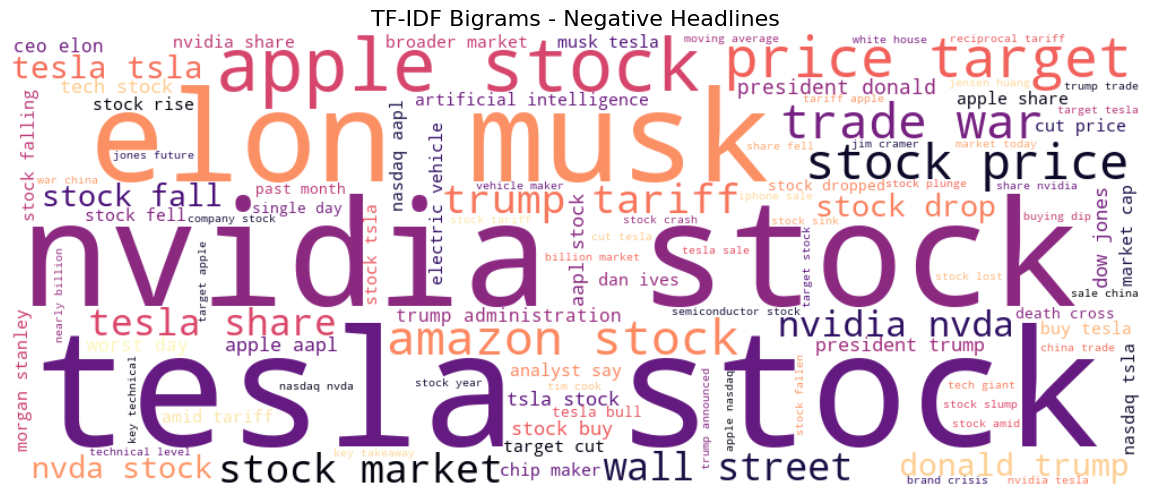

In [54]:

# Function to generate TF-IDF bigram word cloud
def generate_tfidf_bigram_wordcloud(text_series, title, colormap='viridis', max_features=100):
    corpus = text_series.dropna().tolist()

    vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=max_features, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(corpus)

    scores = tfidf_matrix.sum(axis=0).A1
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = dict(zip(feature_names, scores))

    wordcloud = WordCloud(width=1000, height=400, background_color='white', colormap=colormap)
    wordcloud.generate_from_frequencies(tfidf_scores)

    plt.figure(figsize=(12, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate word clouds per sentiment
sentiment_colors = {
    'positive': 'viridis',
    'neutral': 'cividis',
    'negative': 'magma'
}

for sentiment in ['positive', 'neutral', 'negative']:
    subset = df[df['vader_label'] == sentiment]['text_clean']
    generate_tfidf_bigram_wordcloud(
        subset,
        title=f"TF-IDF Bigrams - {sentiment.capitalize()} Headlines",
        colormap=sentiment_colors[sentiment]
    )


**TF-IDF Bigram Insights Across VADER Sentiment Categories**

The TF-IDF bigram analysis provides a focused view of key phrase usage across sentiment-labeled financial headlines:

**• Positive Headlines:**  
Bigrams such as `tesla stock`, `nvidia stock`, `price target`, and `artificial intelligence` reflect a growth-driven, optimistic tone. Phrases like `buy stock` and `long term` emphasize investor confidence and tech-driven opportunity.

**• Neutral Headlines:**  
Key bigrams like `stock price`, `apple stock`, and `president trump` suggest objective or event-based reporting. Terms like `earnings call`, `tariff exemption`, and `quarter report` indicate updates without emotional framing.

**• Negative Headlines:**  
Frequent terms such as `stock fall`, `price target`, `trade war`, and `worst day` reveal market volatility and bearish outlooks. Bigrams like `technical pressure` and `stock plunge` indicate fear, underperformance, or uncertainty.

**Insight:** These bigrams expose how different tones shape financial narratives—highlighting risk in negative coverage and opportunity in positive news.


## Sentiment Analysis with FinBERT <a id='fin_ana'></a>



To complement VADER, we use **FinBERT**, a transformer-based model trained on financial text. It understands deeper linguistic patterns and domain-specific language better than rule-based tools.

**Key Advantages of FinBERT:**
- Understands financial language better than generic models
- Handles phrases that would confuse simpler rule-based tools
- Outputs sentiment as `positive`, `neutral`, or `negative`

I used the `transformers` pipeline from HuggingFace with the `yiyanghkust/finbert-tone` model. The model was applied to each cleaned headline (up to 512 characters) with a progress bar enabled using `tqdm`.


In [68]:
# Enables progress_apply
tqdm.pandas() 

# Load FinBERT model
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up pipeline
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Load your preprocessed file
df = pd.read_csv(r"C:\Users\Mustafa Ansari\Downloads\news_preprocessed.csv")
df = df[df["text_clean"].notnull()].copy()  # Ensuring no nulls

## Setup progress bar + sentiment function
def get_finbert_label(text):
    try:
        result = finbert(text[:512])[0]
        return result["label"].lower()
    except:
        return "error"

# Apply FinBERT
df["finbert_label"] = df["text_clean"].progress_apply(get_finbert_label)


# Preview
print(df["finbert_label"].value_counts())
df[["company", "text_clean", "finbert_label"]].sample(5)

Device set to use cpu
100%|██████████| 1783/1783 [02:25<00:00, 12.26it/s]

neutral     661
positive    620
negative    502
Name: finbert_label, dtype: int64


company                                         text_clean finbert_label
210    Apple  future rise big tariff news look dow jones fut...      positive
450    Tesla  tesla stock worst stretch ever bad news keep c...      negative
1613  Amazon  could buying amazon stock today set life comme...       neutral
1308  Nvidia  top analyst revisits nvidia stock price target...       neutral
1501  Amazon  amazon stock drop softer expected sale outlook...      negative

### FinBert Sentiment Distribution by Company (Count & Percentage)

To get an overview of sentiment trends, we group the sentiment labels by company and count how many headlines were classified as **positive**, **neutral**, or **negative**.

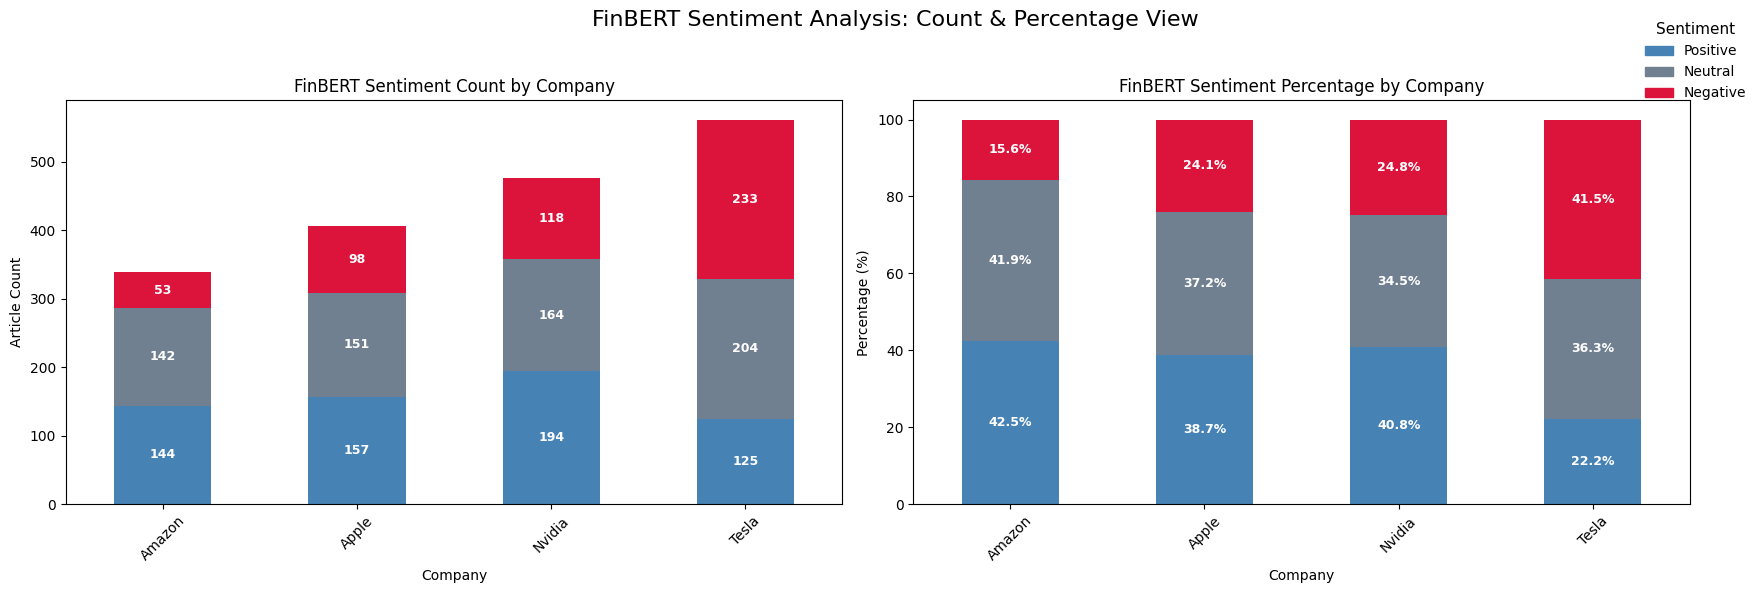

In [56]:

# Group sentiment counts and compute percentages
finbert_sent = df.groupby(["company", "finbert_label"]).size().unstack().fillna(0)
sentiment_order = ["positive", "neutral", "negative"]
finbert_sent = finbert_sent[sentiment_order]
finbert_sent_pct = finbert_sent.div(finbert_sent.sum(axis=1), axis=0) * 100

# Custom Cool Palette
custom_colors = {
    "positive": "#4682B4",   # Steel Blue
    "neutral": "#708090",    # Slate Gray
    "negative": "#DC143C"    # Crimson
}

# Set up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Count
finbert_sent.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    color=[custom_colors[s] for s in sentiment_order],
    legend=False
)
axes[0].set_title("FinBERT Sentiment Count by Company")
axes[0].set_xlabel("Company")
axes[0].set_ylabel("Article Count")
axes[0].tick_params(axis='x', rotation=45)

# Label counts
x_ticks = axes[0].get_xticks()
for i, company in enumerate(finbert_sent.index):
    bottom = 0
    for sentiment in sentiment_order:
        count = finbert_sent.loc[company, sentiment]
        if count > 0:
            axes[0].text(
                x=x_ticks[i],
                y=bottom + count / 2,
                s=int(count),
                ha='center',
                va='center',
                fontsize=9,
                color='white',
                fontweight='bold'
            )
        bottom += count

# Plot 2: Percentage
finbert_sent_pct.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    color=[custom_colors[s] for s in sentiment_order],
    legend=False
)
axes[1].set_title("FinBERT Sentiment Percentage by Company")
axes[1].set_xlabel("Company")
axes[1].set_ylabel("Percentage (%)")
axes[1].tick_params(axis='x', rotation=45)

# Label percentages
x_ticks_pct = axes[1].get_xticks()
for i, company in enumerate(finbert_sent_pct.index):
    bottom = 0
    for sentiment in sentiment_order:
        percent = finbert_sent_pct.loc[company, sentiment]
        if percent >= 5:
            axes[1].text(
                x=x_ticks_pct[i],
                y=bottom + percent / 2,
                s=f"{percent:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white',
                fontweight='bold'
            )
        bottom += percent

# Legend
legend_handles = [Patch(color=custom_colors[s], label=s.capitalize()) for s in sentiment_order]
fig.legend(
    handles=legend_handles,
    title="Sentiment",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

# Layout
plt.suptitle("FinBERT Sentiment Analysis: Count & Percentage View", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()



- **Tesla** has the **highest volume of coverage**, with **562 articles** analyzed. Among these, a substantial **233 were negative**, reinforcing its risk-heavy sentiment profile (**41.5% negative**).
- **Nvidia**, with **476 headlines**, shows a **dominant positive sentiment count** of **194 articles**, closely followed by 164 neutral — highlighting a balanced yet optimistic media perception.
- **Apple** presents a relatively even distribution, with **157 positive**, **151 neutral**, and **98 negative** headlines. The **24.1% negative share** suggests slightly less risk tone compared to Tesla.
- **Amazon** has the **lowest total count** at **339**, but a strong **positive sentiment share** both in count (**144 articles**) and percentage (**42.5%**) — indicating consistently favorable press coverage.

Together, these count and percentage metrics reinforce that **FinBERT captures nuanced financial sentiment**, with Tesla’s volatility reflected in both high article volume and negative tone, while Amazon and Nvidia enjoy more consistently favorable sentiment landscapes.



## TF-IDF Bigram Word Clouds by FinBERT Sentiment 

To explore how language differs across sentiment classes, I am generating word clouds for each sentiment label (positive, neutral, negative) using both FinBERT results.

This helps us visualize the dominant vocabulary associated with different market tones and provides clues about how risk-related vs. opportunity-related terms are distributed across the financial headlines.

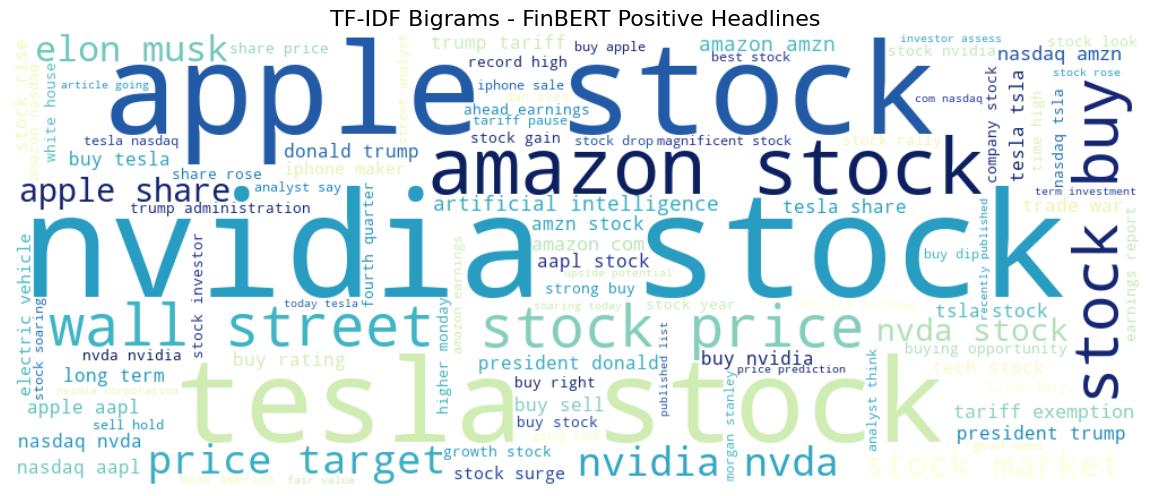

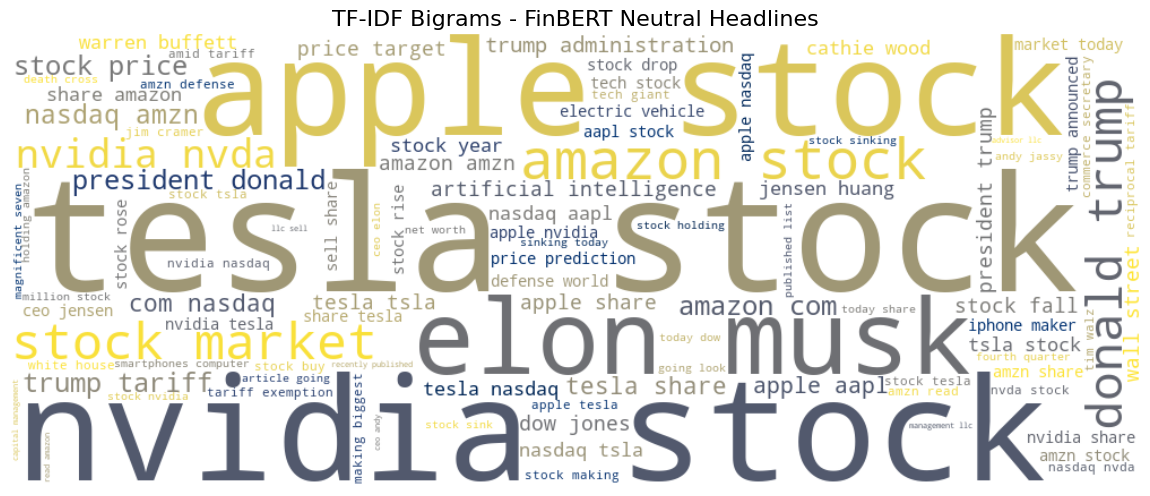

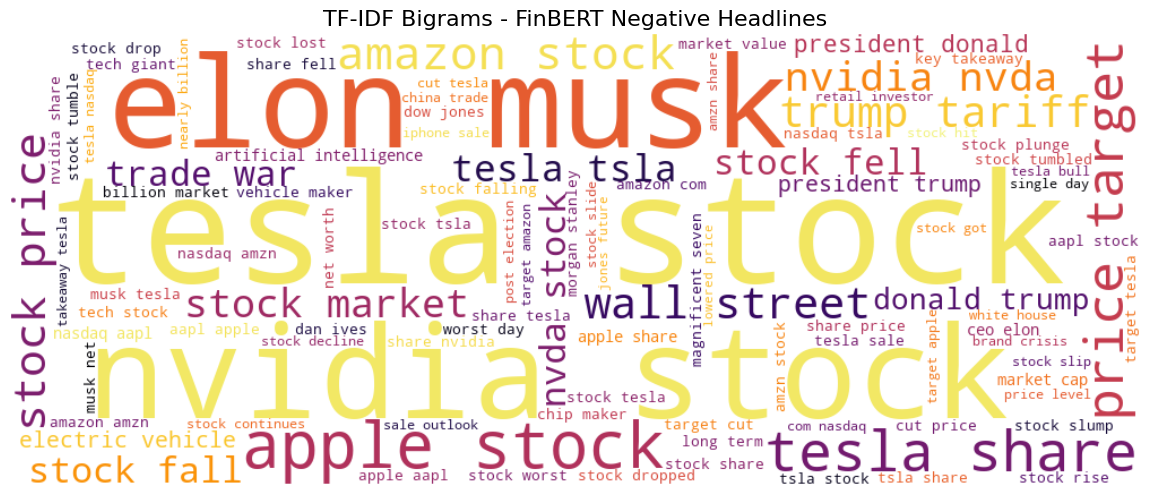

In [57]:
# Function to generate TF-IDF bigram word cloud
def generate_tfidf_bigram_wordcloud(text_series, title, colormap='viridis', max_features=100):
    corpus = text_series.dropna().tolist()

    vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=max_features, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(corpus)

    scores = tfidf_matrix.sum(axis=0).A1
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = dict(zip(feature_names, scores))

    wordcloud = WordCloud(width=1000, height=400, background_color='white', colormap=colormap)
    wordcloud.generate_from_frequencies(tfidf_scores)

    plt.figure(figsize=(12, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate word clouds per FinBERT sentiment
sentiment_colors_finbert = {
    'positive': 'YlGnBu',    # Blue-green
    'neutral': 'cividis',    # Yellow-gray
    'negative': 'inferno'    # Red-black
}

for sentiment in ['positive', 'neutral', 'negative']:
    subset = df[df['finbert_label'] == sentiment]['text_clean']
    generate_tfidf_bigram_wordcloud(
        subset,
        title=f"TF-IDF Bigrams - FinBERT {sentiment.capitalize()} Headlines",
        colormap=sentiment_colors_finbert[sentiment]
    )


**Positive Headlines**
Bigrams like nvidia stock, apple stock, and price target dominate the positive headlines, signaling strong market optimism around leading tech firms. Phrases such as buy rating, long term, and artificial intelligence suggest bullish outlooks and strategic growth expectations.

**Neutral Headlines**
The neutral word cloud is filled with informative bigrams such as tesla stock, donald trump, and price target, reflecting factual reporting without emotional polarity. Frequent mentions of elon musk, nasdaq tsla, and apple aapl imply a focus on financial updates, corporate developments, and policy news.

**Negative Headlines**
Negative sentiment headlines are characterized by impactful bigrams like stock fell, target cut, worst day, and stock plunge. These highlight market declines, bearish revisions, and investor concerns. Repeated mentions of tesla, nvidia, and elon musk suggest that these high-profile entities are central to volatility and negative press. Terms like trade war and price drop reflect broader economic unease.



## Comparison of Sentiments: VADER vs FinBert <a id='Sen_Comp'></a>

Now that all financial news headlines are classified using both **VADER** and **FinBERT**, I would like to compare their sentiment predictions.

- **VADER** is a lexicon-based tool designed for social media and short text.
- **FinBERT** is a domain-specific transformer trained on financial texts.

This comparison highlights:
- How often the tools agree
- Where they differ (and possibly why)
- Overall sentiment distribution across models

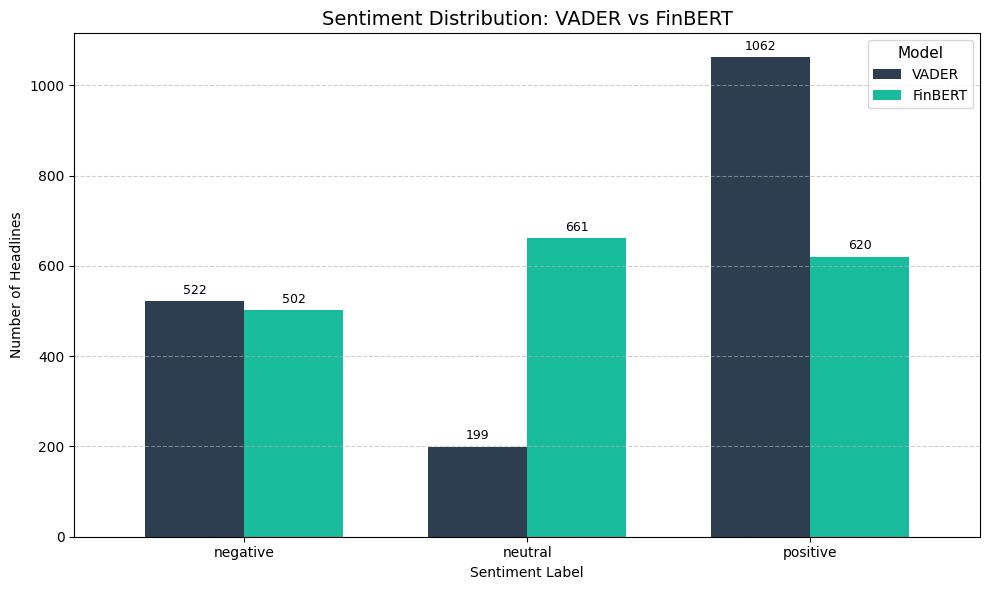

In [60]:
# side-by-side sentiment comparison

comparison_df = pd.DataFrame({
    "VADER": df["vader_label"].value_counts().sort_index(),
    "FinBERT": df["finbert_label"].value_counts().sort_index()
})

# Plot
ax = comparison_df.plot(kind="bar", figsize=(10, 6), rot=0, width=0.7,
                        color=["#2c3e50", "#18bc9c"])  # 
plt.title("Sentiment Distribution: VADER vs FinBERT", fontsize=14)
plt.ylabel("Number of Headlines")
plt.xlabel("Sentiment Label")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Model", fontsize=10, title_fontsize=11)

# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height + 10),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


The bar chart above shows the overall sentiment distribution predicted by both VADER and FinBERT:

- **VADER** classifies a significantly larger number of headlines as **positive** (1,062), while **FinBERT** is more conservative with only **620** positives.
- For the **neutral** class, FinBERT detects **661** headlines compared to just **199** from VADER, indicating its nuanced interpretation of financial tone.
- Both models show close agreement on the **negative** sentiment class, with **VADER at 522** and **FinBERT at 502**.

This discrepancy reflects FinBERT’s domain-specific understanding of financial language versus VADER’s rule-based, general-purpose design.


### Agreement/Disagreement Matrix

In [61]:
# Cross-tab to compare predictions
agreement = pd.crosstab(df["vader_label"], df["finbert_label"])

# Show it
print("VADER vs FinBERT Agreement Matrix:")
display(agreement)


VADER vs FinBERT Agreement Matrix:


finbert_label  negative  neutral  positive
vader_label                               
negative            281      149        92
neutral              40      101        58
positive            181      411       470

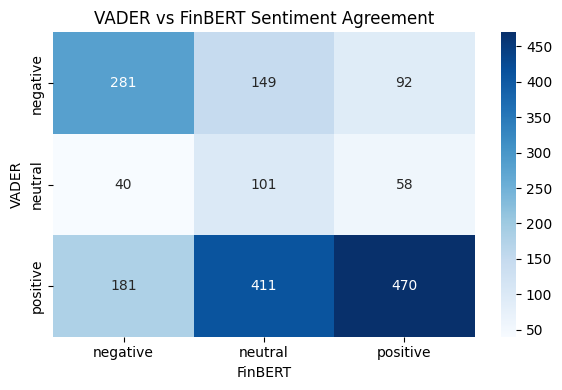

In [62]:
plt.figure(figsize=(6, 4))
sns.heatmap(agreement, annot=True, fmt='d', cmap="Blues")
plt.title("VADER vs FinBERT Sentiment Agreement")
plt.ylabel("VADER")
plt.xlabel("FinBERT")
plt.tight_layout()
plt.show()


Key takeaways:

- **470 headlines** were **labeled positive by both** VADER and FinBERT — showing high agreement.
- VADER labeled **181 headlines as positive** that FinBERT marked **as negative**, which may indicate over-optimism from VADER.
- FinBERT labeled **149 VADER-negative headlines as neutral**, suggesting FinBERT avoids extreme sentiment unless strongly implied.
- FinBERT appears more cautious and nuanced — more in line with financial tone expectations.

This comparison shows the importance of using a **domain-specific model like FinBERT** when dealing with financial sentiment analysis.

In [63]:
# Add a column to flag whether both models agree
df['sentiment_agreement'] = df['vader_label'] == df['finbert_label']

# Compute the overall agreement rate
agreement_rate = df['sentiment_agreement'].mean()
print(f"Sentiment Match Rate: {agreement_rate:.2%}")

Sentiment Match Rate: 47.78%


### Sentiment Disagreements percentage and sample

In [64]:
# Combine all sentiment summaries
sentiment_summary = df.groupby('company').apply(
    lambda x: pd.Series({
        'FinBERT Positive %': (x['finbert_label'] == 'positive').mean() * 100,
        'VADER Positive %': (x['vader_label'] == 'positive').mean() * 100,
        'FinBERT Neutral %': (x['finbert_label'] == 'neutral').mean() * 100,
        'VADER Neutral %': (x['vader_label'] == 'neutral').mean() * 100,
        'FinBERT Negative %': (x['finbert_label'] == 'negative').mean() * 100,
        'VADER Negative %': (x['vader_label'] == 'negative').mean() * 100
    })
).reset_index()

# Display clean DataFrame
print(sentiment_summary.round(2))


  company  FinBERT Positive %  VADER Positive %  FinBERT Neutral %  \
0  Amazon               42.48             85.25              41.89   
1   Apple               38.67             57.64              37.19   
2  Nvidia               40.76             54.20              34.45   
3   Tesla               22.24             50.00              36.30   

   VADER Neutral %  FinBERT Negative %  VADER Negative %  
0             2.06               15.63             12.68  
1            14.53               24.14             27.83  
2            14.71               24.79             31.09  
3            11.21               41.46             38.79  


In [65]:
# Show a few headlines where they disagreed

disagreements = df[df["vader_label"] != df["finbert_label"]]
disagreements[["company", "text_clean", "vader_label", "finbert_label"]].sample(5)


company                                         text_clean vader_label  \
851    Tesla  stock moved today walmart apple tesla delta br...    positive   
1552  Amazon  best stock buy right costco amazon stock marke...    positive   
758    Tesla  tesla stock face tug war musk deepens politica...    negative   
121    Apple  forget tariff apple stock could deal decade ma...    negative   
1732  Amazon  amazon amzn prime could send share soaring one...    positive   

     finbert_label  
851        neutral  
1552      negative  
758        neutral  
121        neutral  
1732       neutral

## Named Entity Recognition (NER) <a id='name_reco'></a>

To uncover the **key entities** present in financial news, i applied `spaCy`'s `en_core_web_sm` model to extract named entities from each headline. This allows us to identify and analyze recurring mentions of:

- **Organizations** (e.g., Apple, Tesla, SEC)
- **People** (e.g., Elon Musk, Jensen Huang)
- **Dates**, **Money**, and **Locations** relevant to financial context

We then compute the frequency of each entity type to understand the **dominant semantic categories** in the headlines.


In [66]:
# Load the lightweight spaCy NER model
nlp = spacy.load("en_core_web_sm")

# Load your cleaned dataset
df = pd.read_csv(r"C:\Users\Mustafa Ansari\Downloads\news_preprocessed.csv")
df = df[df["text_clean"].notnull()].copy()

# Extract entities
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply to headlines
df["named_entities"] = df["text_clean"].progress_apply(extract_entities)

# Flatten and count entity labels
all_entities = [label for ents in df["named_entities"] for (_, label) in ents]
entity_freq = Counter(all_entities)

# Display top 10
print("Top 10 Named Entity Types:")
print(entity_freq.most_common(10))


100%|██████████| 1783/1783 [00:09<00:00, 186.84it/s]

Top 10 Named Entity Types:
[('DATE', 1296), ('ORG', 976), ('PERSON', 457), ('CARDINAL', 283), ('GPE', 234), ('NORP', 90), ('TIME', 79), ('ORDINAL', 68), ('LOC', 21), ('MONEY', 12)]


### Top 10 Named Entity Types
Based on the analysis, the most frequently detected entity types were:

| Entity Type | Frequency |
|-------------|-----------|
| `DATE`      | 1296      |
| `ORG`       | 976       |
| `PERSON`    | 457       |
| `CARDINAL`  | 283       |
| `GPE`       | 234       |
| `NORP`      | 90        |
| `TIME`      | 79        |
| `ORDINAL`   | 68        |
| `LOC`       | 21        |
| `MONEY`     | 12        |

These results highlight the **temporal nature** of financial news (`DATE`, `TIME`) and the focus on **companies and individuals** (`ORG`, `PERSON`) driving market sentiment.


### Entity Frequency by Sentiment Label

To better understand the relationship between entities mentioned in headlines and the tone of the article, we count how often entities of each type appear under each sentiment class.This approach helps answer questions like:
- *Are certain entity types more likely to co-occur with negative headlines?*
- *Which categories dominate in positive or neutral contexts?*

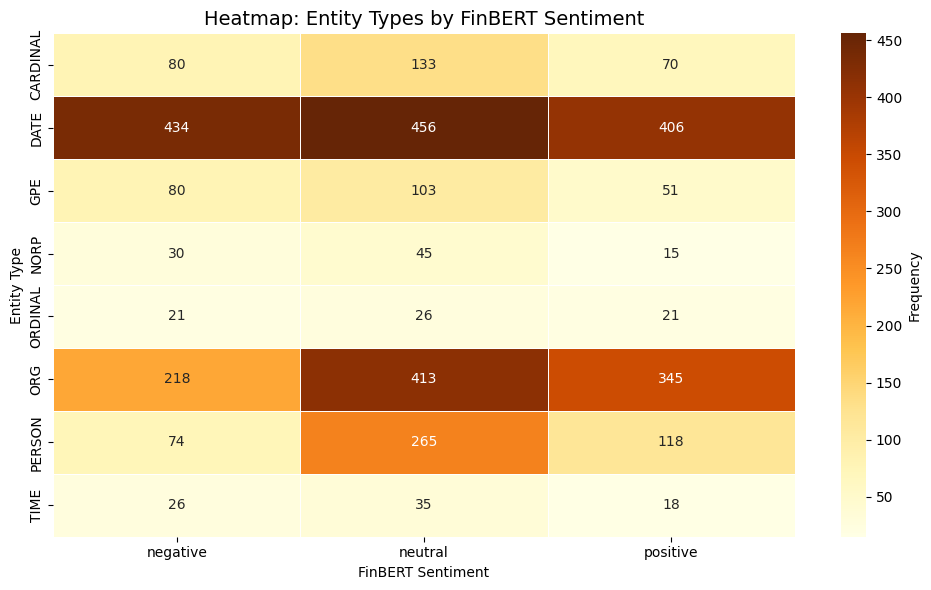

In [69]:
# Filter necessary columns and drop nulls
df_entities = df[["text_clean", "finbert_label"]].dropna()

# Extract (entity_type, sentiment) pairs
entity_sentiment_pairs = []
for doc, label in zip(nlp.pipe(df_entities["text_clean"], batch_size=50), df_entities["finbert_label"]):
    for ent in doc.ents:
        entity_sentiment_pairs.append((ent.label_, label))

# Convert to DataFrame
entity_df = pd.DataFrame(entity_sentiment_pairs, columns=["entity_type", "sentiment"])

# Count entity-sentiment frequencies
entity_counts = entity_df.groupby(["entity_type", "sentiment"]).size().reset_index(name="count")

# Get top 8 entity types
top_entities = entity_df["entity_type"].value_counts().head(8).index
filtered = entity_counts[entity_counts["entity_type"].isin(top_entities)]

# Pivot for heatmap format
heatmap_data = filtered.pivot(index="entity_type", columns="sentiment", values="count").fillna(0)

# Normalize rows to see proportional sentiment share per entity type (optional)
# heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="YlOrBr",   # Your requested colormap
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Frequency'}
)

plt.title("Heatmap: Entity Types by FinBERT Sentiment", fontsize=14)
plt.xlabel("FinBERT Sentiment")
plt.ylabel("Entity Type")
plt.tight_layout()
plt.show()



`DATE` and `ORG` are the most frequently mentioned entities across all sentiment labels, showing their **central role** in financial reporting.

`ORG` (Organizations) lean more towards **positive** and **neutral** sentiment, suggesting company-related headlines often report earnings, expansions, or product launches.

`PERSON` entities show more **neutral** sentiment, likely due to quotes or statements from executives or analysts.

`CARDINAL`, `ORDINAL`, and `TIME` often appear across sentiment labels—indicating that numerical references (e.g., revenue, rank, time periods) are core components of financial news but don’t inherently carry polarity.

`GPE` (Countries/Regions) and `NORP` (Nationalities/Groups) show up mostly in **neutral** to negative sentiment, hinting at discussions around macroeconomic or geopolitical concerns.



### Sentiment Over Time Using DATE Entities 

Here I would like to analyze how FinBERT sentiment labels vary across different dates mentioned in the headlines — based on spaCy's DATE named entities.

So that the media tone over time (e.g., are headlines about "Q1", "April", or "next week" more negative?) can be tracked. and also see if certain periods are associated with higher risk sentiment.

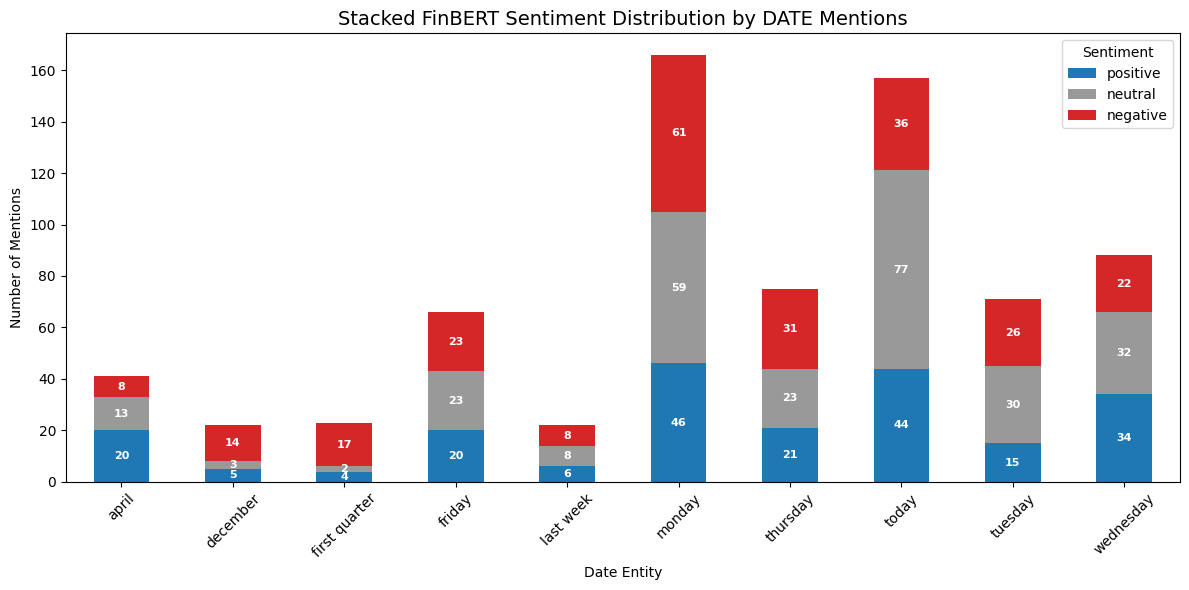

In [70]:
# Filter required columns
df_dates = df[["text_clean", "finbert_label"]].dropna()

# Extract (DATE entity, FinBERT label) pairs
date_sentiment_pairs = []
for _, row in df_dates.iterrows():
    doc = nlp(row["text_clean"])
    for ent in doc.ents:
        if ent.label_ == "DATE":
            date_sentiment_pairs.append((ent.text.lower(), row["finbert_label"]))

# Create DataFrame
df_date_sentiment = pd.DataFrame(date_sentiment_pairs, columns=["date_entity", "finbert_label"])

# Get top 10 mentioned dates
top_dates = df_date_sentiment["date_entity"].value_counts().head(10).index
df_top_dates = df_date_sentiment[df_date_sentiment["date_entity"].isin(top_dates)]

# Aggregate counts
count_df = df_top_dates.groupby(["date_entity", "finbert_label"]).size().unstack(fill_value=0)
count_df = count_df[["positive", "neutral", "negative"]]  # Ensure column order

# Plot stacked bar chart
colors = {"positive": "#1f77b4", "neutral": "#999999", "negative": "#d62728"}
ax = count_df.plot(kind="bar", stacked=True, figsize=(12, 6), color=[colors[c] for c in count_df.columns])

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=8, color='white', fontweight='bold')

plt.title("Stacked FinBERT Sentiment Distribution by DATE Mentions", fontsize=14)
plt.xlabel("Date Entity")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


`Weekday` mentions dominate, especially **Monday** and **Today**, which show higher negative and neutral sentiment - likely reflecting reactions to news cycles starting or real-time market volatility.

`Friday` stands out with relatively **balanced** sentiment, possibly signaling both wrap-up optimism and risk caution before weekends.

`First Quarter` and `December` exhibit strong **negative** tones, potentially linked to financial reports or end-of-year performance concerns.

Mentions of `April` and `last week` skew more **positive** or **neutral**, suggesting a less emotionally charged news tone.

This temporal sentiment mapping helps reveal when risk perception peaks — supporting the development of our sentiment-based risk scoring system.

## Stock Price Data Collection and Sentiment Correlation <a id='stock_corr'></a>

In this section, I fetch historical stock prices for Apple (AAPL), Tesla (TSLA), Nvidia (NVDA), and Amazon (AMZN) using the yfinance API, spanning Dec 01, 2024, to April 14, 2025. I aggregate FinBERT sentiment scores by date and company, aligning them with daily stock data. I calculate daily returns and 7-day volatility to gauge market trends, then compute correlations between positive and negative sentiment and market metrics. Time-series and scatter plots visualize sentiment spikes alongside price movements and volatility, testing if news sentiment signals financial risk.

### Positive News correlation

Available columns: [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'NVDA'), ('Close', 'TSLA'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'NVDA'), ('High', 'TSLA'), ('Low', 'AAPL'), ('Low', 'AMZN'), ('Low', 'NVDA'), ('Low', 'TSLA'), ('Open', 'AAPL'), ('Open', 'AMZN'), ('Open', 'NVDA'), ('Open', 'TSLA'), ('Volume', 'AAPL'), ('Volume', 'AMZN'), ('Volume', 'NVDA'), ('Volume', 'TSLA')]
Shape after selecting 'Close': (93, 4)
Columns after melt: ['Date', 'company', 'close_price']
Sample stock_data:
   company        date  close_price
0   Apple  12/02/2024   239.326859
1   Apple  12/03/2024   242.383499
2   Apple  12/04/2024   242.743103
3   Apple  12/05/2024   242.773071
4   Apple  12/06/2024   242.573288
Stock data date range: 01/02/2025 to 12/31/2024
Sentiment data date range: 01/15/2025 to 04/14/2025
Merged DataFrame shape: (372, 6)
Correlation Matrix (Positive Sentiment):
             company
returns     Amazon     0.032632
            Apple      0.362434
            Nvidia     0.2288

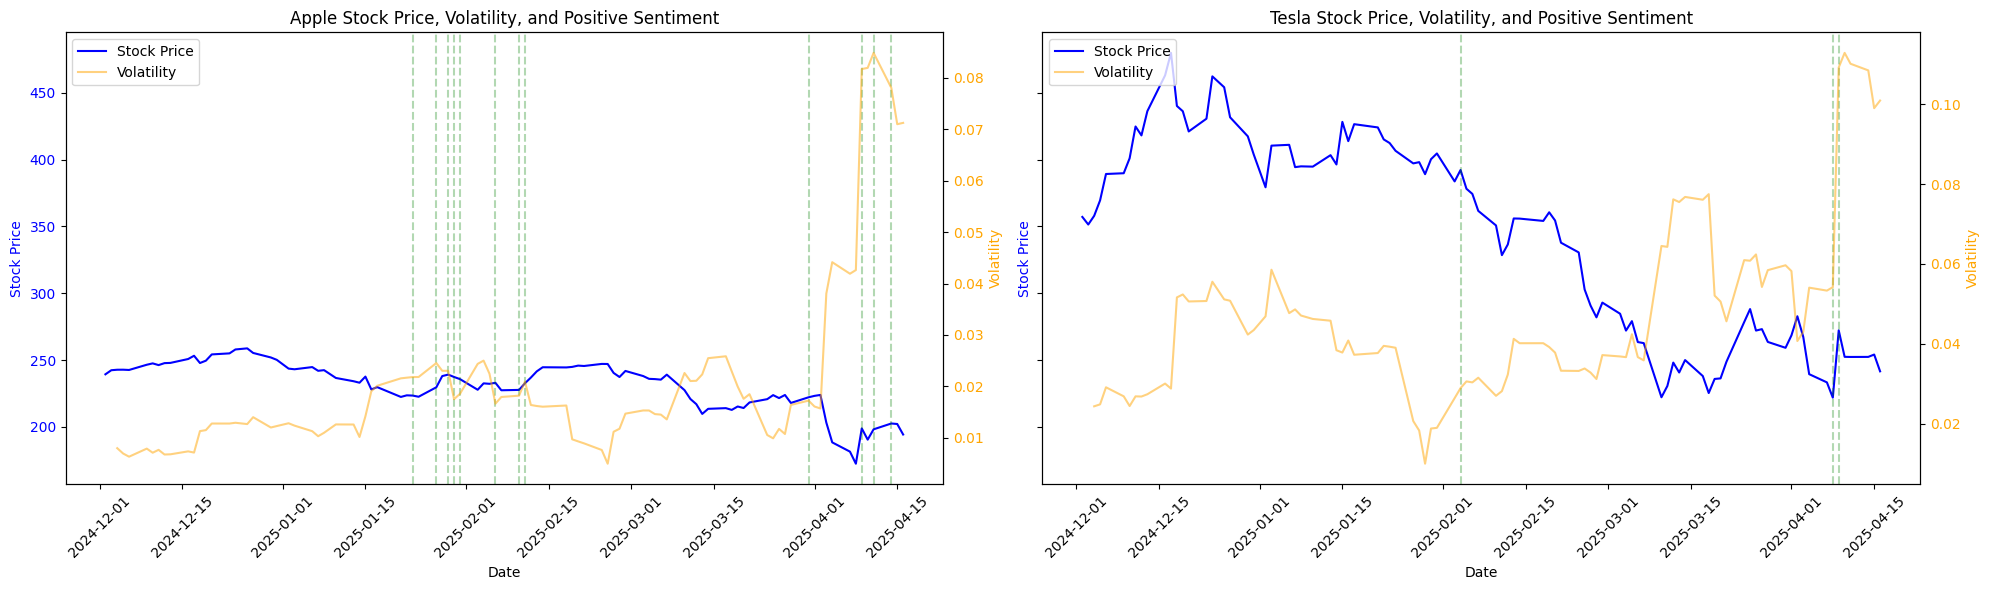

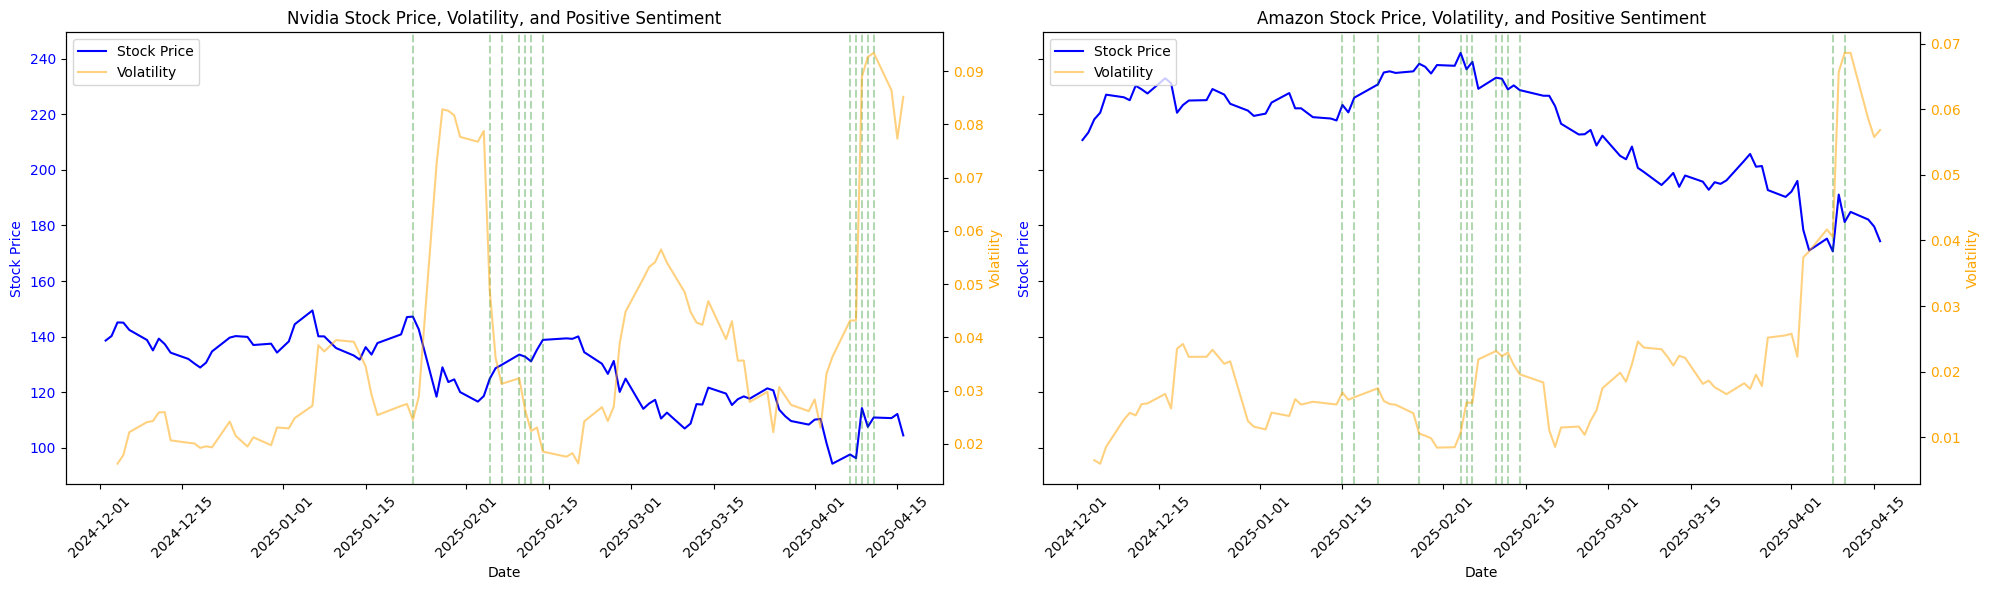

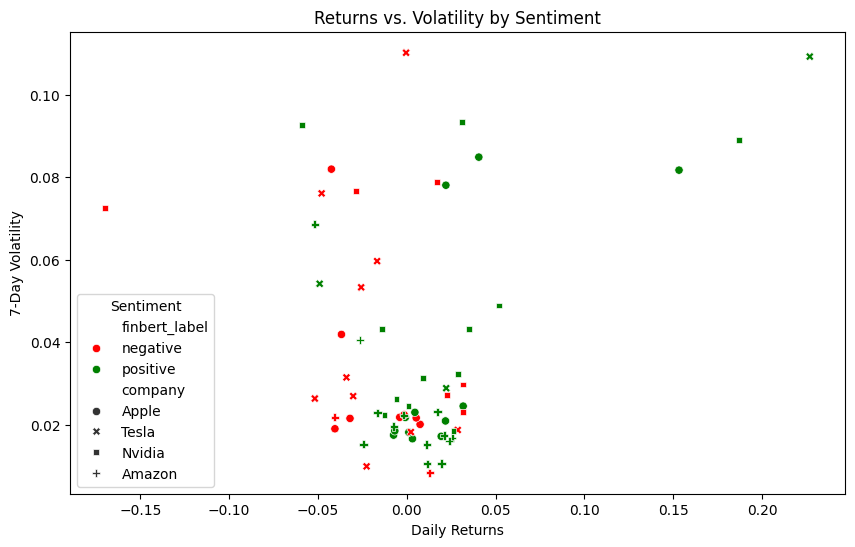

In [71]:
# Collect stock price data with error handling
tickers = ["AAPL", "TSLA", "NVDA", "AMZN"]
try:
    stock_data = yf.download(tickers, start="2024-12-01", end="2025-04-17", progress=False)
    if stock_data.empty:
        raise ValueError("No data returned from yfinance for the specified tickers and date range.")
    print("Available columns:", stock_data.columns.tolist())
    stock_data = stock_data["Close"]
    print("Shape after selecting 'Close':", stock_data.shape)
except Exception as e:
    print(f"Error fetching stock data: {e}")
    stock_data = pd.DataFrame()

# Reshape stock data to long format
if not stock_data.empty:
    stock_data = stock_data.reset_index().melt(id_vars=["Date"], value_vars=tickers, 
                                              var_name="company", value_name="close_price")
    print("Columns after melt:", stock_data.columns.tolist())
    stock_data = stock_data.rename(columns={"Date": "date"})
    stock_data["company"] = stock_data["company"].map({"AAPL": "Apple", "TSLA": "Tesla", "NVDA": "Nvidia", "AMZN": "Amazon"})
    stock_data["date"] = pd.to_datetime(stock_data["date"]).dt.strftime("%m/%d/%Y")
    
    print("Sample stock_data:\n", stock_data[["company", "date", "close_price"]].head())
    print("Stock data date range:", stock_data["date"].min(), "to", stock_data["date"].max())
    
    stock_data["returns"] = stock_data.groupby("company")["close_price"].pct_change()
    stock_data["volatility"] = stock_data.groupby("company")["returns"].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)
else:
    print("Skipping further processing due to empty stock data.")
    stock_data = pd.DataFrame(columns=["company", "date", "close_price", "returns", "volatility"])

# Aggregate sentiment scores by date and company
sentiment_df = df[["company", "published", "finbert_label"]].copy()
sentiment_df["published"] = pd.to_datetime(sentiment_df["published"]).dt.strftime("%m/%d/%Y")
sentiment_df = sentiment_df.groupby(["company", "published"]).agg({
    "finbert_label": lambda x: pd.Series.mode(x)[0]
}).reset_index().rename(columns={"published": "date"})

print("Sentiment data date range:", sentiment_df["date"].min(), "to", sentiment_df["date"].max())

# Merge stock and sentiment data 
merged_df = pd.merge(stock_data, sentiment_df, on=["company", "date"], how="left")
merged_df["finbert_label"] = merged_df["finbert_label"].fillna("neutral")
print("Merged DataFrame shape:", merged_df.shape)

# Calculate correlations
if not merged_df.empty:
    correlation_matrix = merged_df.groupby("company").apply(
        lambda x: x[["returns", "volatility"]].corrwith(
            pd.get_dummies(x["finbert_label"])["positive"]
        )
    ).unstack()
    print("Correlation Matrix (Positive Sentiment):\n", correlation_matrix)
else:
    print("No merged data available for correlation analysis.")
    correlation_matrix = pd.DataFrame()

# Visualize positive sentiment vs. stock price and volatility
if not merged_df.empty:
    # Pair 1: Apple and Tesla
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Apple plot
    company_data = merged_df[merged_df["company"] == "Apple"]
    ax1.set_title("Apple Stock Price, Volatility, and Positive Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax1.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Tesla plot
    company_data = merged_df[merged_df["company"] == "Tesla"]
    ax2.set_title("Tesla Stock Price, Volatility, and Positive Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax2.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Pair 2: Nvidia and Amazon
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Nvidia plot
    company_data = merged_df[merged_df["company"] == "Nvidia"]
    ax1.set_title("Nvidia Stock Price, Volatility, and Positive Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax1.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Amazon plot
    company_data = merged_df[merged_df["company"] == "Amazon"]
    ax2.set_title("Amazon Stock Price, Volatility, and Positive Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "positive":
            ax2.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Scatter plot 
    filtered_df = merged_df[merged_df["finbert_label"] != "neutral"]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=filtered_df, 
        x="returns", 
        y="volatility", 
        hue="finbert_label", 
        style="company", 
        palette={"negative": "red", "positive": "green"}
    )
    plt.title("Returns vs. Volatility by Sentiment")
    plt.xlabel("Daily Returns")
    plt.ylabel("7-Day Volatility")
    plt.legend(title="Sentiment")
    plt.show()



**The time-series plots display stock prices (blue line) and volatility (yellow line), with green dashed lines marking days of positive news sentiment. The scatter plot shows how daily returns relate to volatility, colored by sentiment (blue for neutral, orange for negative, green for positive).**


**Apple** hovered around `$200` in February 2025, rising to `$210` by mid-March with positive sentiment markers, and ended at `$196.316` in April. Volatility dropped to 0.02 during these gains, suggesting good news fueled optimism.

**Tesla** saw gains from `$230` in March 2025 to `$250` by early April, ending at `$235.25`. Volatility stabilized at 0.03 during positive sentiment periods, indicating confidence.

**Nvidia** climbed from `$115` in February to `$125` by March with positive news, ending at `$117.82` in April. Volatility was low at 0.02, reflecting stability.

**Amazon** rose from `$185` in March to `$195` by early April, ending at $186.6. Volatility stayed at 0.02 during positive news days.

**The scatter plot shows positive sentiment (green) often ties to lower volatility (0.02–0.04) and positive returns (0.05–0.15), indicating stability and growth.**

*Positive sentiment, marked by green lines, often aligned with price gains or stability, suggesting news boosted investor confidence. For example, Tesla’s rise in March 2025 might have been driven by positive news like a major EV battery breakthrough or expanded market share, reducing volatility as investors reacted favorably. The scatter plot confirms that positive news typically leads to stable prices (lower volatility) and gains (positive returns), while negative news (orange) aligns with losses.*

### Negative News Correlation

Available columns: [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'NVDA'), ('Close', 'TSLA'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'NVDA'), ('High', 'TSLA'), ('Low', 'AAPL'), ('Low', 'AMZN'), ('Low', 'NVDA'), ('Low', 'TSLA'), ('Open', 'AAPL'), ('Open', 'AMZN'), ('Open', 'NVDA'), ('Open', 'TSLA'), ('Volume', 'AAPL'), ('Volume', 'AMZN'), ('Volume', 'NVDA'), ('Volume', 'TSLA')]
Shape after selecting 'Close': (93, 4)
Columns after melt: ['Date', 'company', 'close_price']
Sample stock_data:
   company        date  close_price
0   Apple  12/02/2024   239.326859
1   Apple  12/03/2024   242.383499
2   Apple  12/04/2024   242.743103
3   Apple  12/05/2024   242.773071
4   Apple  12/06/2024   242.573288
Stock data date range: 01/02/2025 to 12/31/2024
Sentiment data date range: 01/15/2025 to 04/14/2025
Merged DataFrame shape: (372, 6)
Correlation Matrix:
             company
returns     Amazon    -0.073022
            Apple     -0.182258
            Nvidia    -0.084202
            Tesla 

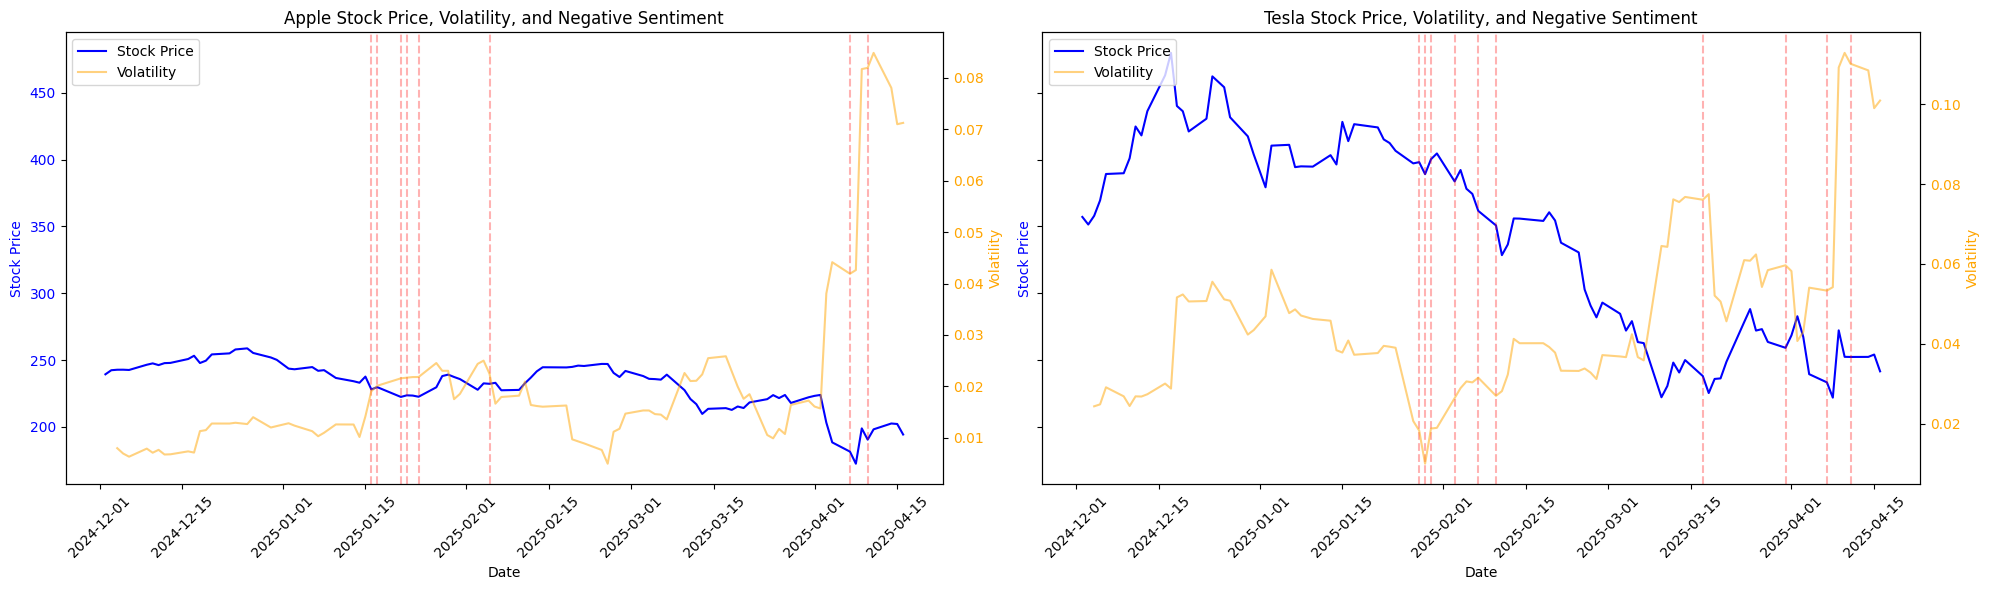

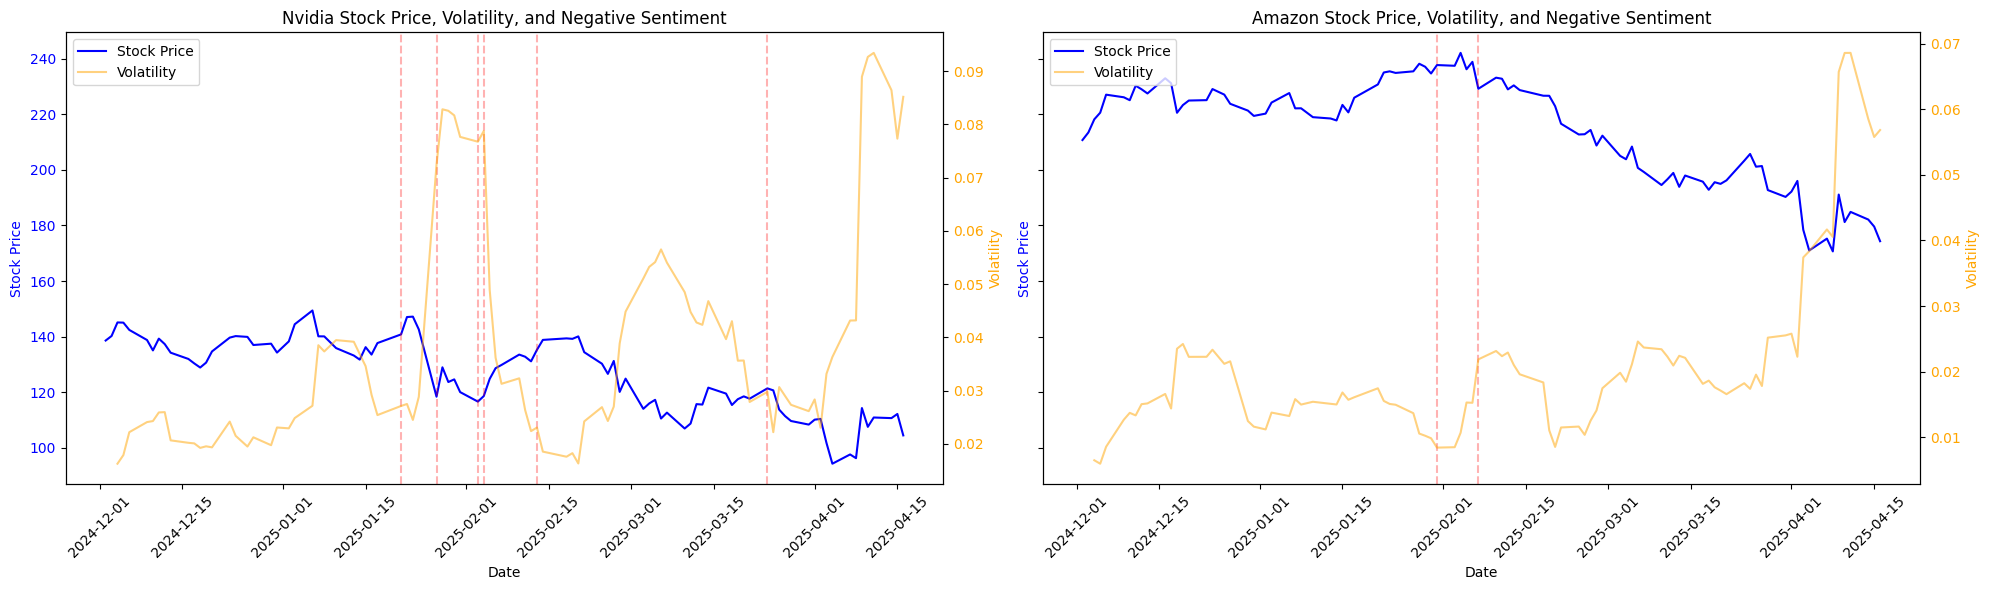

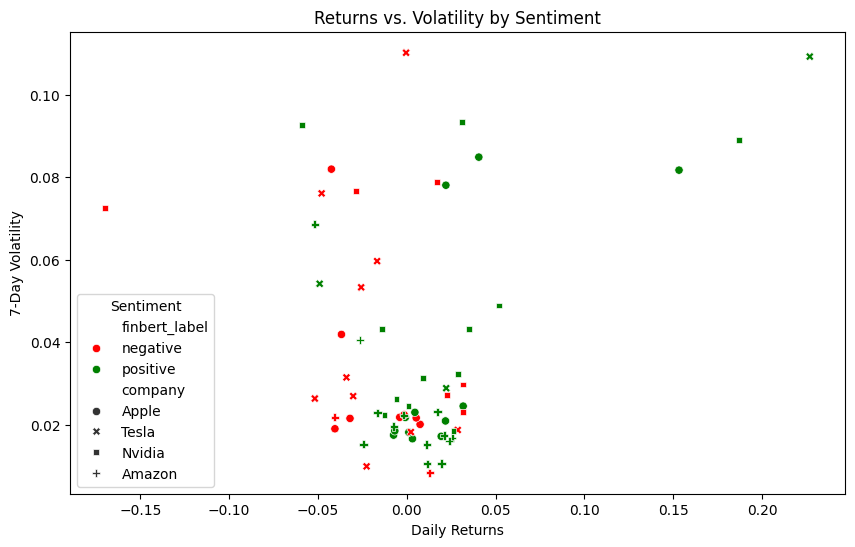

In [72]:
# Collect stock price data with error handling
tickers = ["AAPL", "TSLA", "NVDA", "AMZN"]
try:
    stock_data = yf.download(tickers, start="2024-12-01", end="2025-04-17", progress=False)
    if stock_data.empty:
        raise ValueError("No data returned from yfinance for the specified tickers and date range.")
    print("Available columns:", stock_data.columns.tolist())
    stock_data = stock_data["Close"]
    print("Shape after selecting 'Close':", stock_data.shape)
except Exception as e:
    print(f"Error fetching stock data: {e}")
    stock_data = pd.DataFrame()

# Reshape stock data to long format
if not stock_data.empty:
    stock_data = stock_data.reset_index().melt(id_vars=["Date"], value_vars=tickers, 
                                              var_name="company", value_name="close_price")
    print("Columns after melt:", stock_data.columns.tolist())
    stock_data = stock_data.rename(columns={"Date": "date"})
    stock_data["company"] = stock_data["company"].map({"AAPL": "Apple", "TSLA": "Tesla", "NVDA": "Nvidia", "AMZN": "Amazon"})
    stock_data["date"] = pd.to_datetime(stock_data["date"]).dt.strftime("%m/%d/%Y")
    
    print("Sample stock_data:\n", stock_data[["company", "date", "close_price"]].head())
    print("Stock data date range:", stock_data["date"].min(), "to", stock_data["date"].max())
    
    stock_data["returns"] = stock_data.groupby("company")["close_price"].pct_change()
    stock_data["volatility"] = stock_data.groupby("company")["returns"].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)
else:
    print("Skipping further processing due to empty stock data.")
    stock_data = pd.DataFrame(columns=["company", "date", "close_price", "returns", "volatility"])

# Aggregate sentiment scores by date and company
sentiment_df = df[["company", "published", "finbert_label"]].copy()
sentiment_df["published"] = pd.to_datetime(sentiment_df["published"]).dt.strftime("%m/%d/%Y")
sentiment_df = sentiment_df.groupby(["company", "published"]).agg({
    "finbert_label": lambda x: pd.Series.mode(x)[0]
}).reset_index().rename(columns={"published": "date"})

print("Sentiment data date range:", sentiment_df["date"].min(), "to", sentiment_df["date"].max())

# Merge stock and sentiment data 
merged_df = pd.merge(stock_data, sentiment_df, on=["company", "date"], how="left")
merged_df["finbert_label"] = merged_df["finbert_label"].fillna("neutral")
print("Merged DataFrame shape:", merged_df.shape)

# Calculate correlations
if not merged_df.empty:
    correlation_matrix = merged_df.groupby("company").apply(
        lambda x: x[["returns", "volatility"]].corrwith(
            pd.get_dummies(x["finbert_label"])["negative"]
        )
    ).unstack()
    print("Correlation Matrix:\n", correlation_matrix)
else:
    print("No merged data available for correlation analysis.")
    correlation_matrix = pd.DataFrame()

# Visualize negative sentiment vs. stock price and volatility 
if not merged_df.empty:
    # Pair 1: Apple and Tesla
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Apple plot
    company_data = merged_df[merged_df["company"] == "Apple"]
    ax1.set_title("Apple Stock Price, Volatility, and Negative Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax1.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Tesla plot
    company_data = merged_df[merged_df["company"] == "Tesla"]
    ax2.set_title("Tesla Stock Price, Volatility, and Negative Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax2.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Pair 2: Nvidia and Amazon
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")
    
    # Nvidia plot
    company_data = merged_df[merged_df["company"] == "Nvidia"]
    ax1.set_title("Nvidia Stock Price, Volatility, and Negative Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    line1, = ax1.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.tick_params(axis="x", rotation=45)
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel("Volatility", color="orange")
    line2, = ax1b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax1b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax1.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Amazon plot
    company_data = merged_df[merged_df["company"] == "Amazon"]
    ax2.set_title("Amazon Stock Price, Volatility, and Negative Sentiment")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Stock Price", color="blue")
    line1, = ax2.plot(pd.to_datetime(company_data["date"]), company_data["close_price"], color="blue", label="Stock Price")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.tick_params(axis="x", rotation=45)
    
    ax2b = ax2.twinx()
    ax2b.set_ylabel("Volatility", color="orange")
    line2, = ax2b.plot(pd.to_datetime(company_data["date"]), company_data["volatility"], color="orange", alpha=0.5, label="Volatility")
    ax2b.tick_params(axis="y", labelcolor="orange")
    
    for _, row in company_data.iterrows():
        if row["finbert_label"] == "negative":
            ax2.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc="upper left")
    
    plt.tight_layout()
    plt.show()

    # Scatter plot 
    filtered_df = merged_df[merged_df["finbert_label"] != "neutral"]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=filtered_df, 
        x="returns", 
        y="volatility", 
        hue="finbert_label", 
        style="company", 
        palette={"negative": "red", "positive": "green"}
    )
    plt.title("Returns vs. Volatility by Sentiment")
    plt.xlabel("Daily Returns")
    plt.ylabel("7-Day Volatility")
    plt.legend(title="Sentiment")
    plt.show()


**The time-series plots display stock prices (blue line) and volatility (yellow line), with red dashed lines marking days of negative news sentiment. The scatter plot shows how daily returns relate to volatility, colored by sentiment (blue for neutral, orange for negative, green for positive).**


**Apple** started at `$250` in December 2024, dropped to `$190` by mid-January 2025, and ended at `$196.316` in April. Volatility spiked to `0.07` during the January drop, with negative sentiment markers suggesting **bad news triggered the decline**.

**Tesla** fell from `$400` to `$250` by February 2025, with volatility peaking at `0.10`, then stabilized at `$235.25` by April. Negative sentiment in January and February aligned with price drops.

**Nvidia** declined from `$140` to `$110` by March 2025, ending at `$117.82`, with volatility at `0.08` during negative sentiment periods.

**Amazon** dropped from `$230` to `$180` by March, ending at `$186.6`, with volatility at `0.05` during negative news days.

**The scatter plot shows negative sentiment (orange) often ties to higher volatility (0.05–0.08) and negative returns (-0.10 to 0.00), indicating risk.**

*Negative sentiment, marked by red lines, often preceded price drops, suggesting news impacted investor confidence. For example, Tesla’s drop in January 2025 might have been due to negative news like production delays or regulatory challenges, causing volatility to spike as investors reacted. Also, tariffs, likely amplified uncertainty for companies reliant on global supply chains, like Tesla. The scatter plot confirms that negative news typically leads to unstable prices (higher volatility) and losses (negative returns), while positive news (green) aligns with gains.*

**The scatter plot confirms that negative news typically leads to unstable prices (higher volatility) and losses (negative returns), while positive news (green) aligns with gains.**

## Topic Modeling for News Themes Driving Financial Risk <a id='top_mod'></a>

In this section, I apply topic modeling to news articles for Apple, Tesla, Nvidia, and Amazon from December 2024 to April 2025 to uncover themes driving financial risk.The topics are extracted using Latent Dirichlet Allocation (LDA) and are presented as proportions of total news coverage per day.
This helps to identify emerging themes and shifts in media attention related to Apple, Tesla, Nvidia, and Amazon. 


Topics for Apple:
Topic 1: 0.074*"tariff" + 0.043*"trump" + 0.034*"share" + 0.030*"president" + 0.029*"aapl"
Topic 2: 0.053*"aapl" + 0.052*"tariff" + 0.044*"trump" + 0.035*"price" + 0.033*"tech"
Topic 3: 0.053*"iphone" + 0.053*"analyst" + 0.037*"price" + 0.035*"aapl" + 0.029*"ai"
Topic 4: 0.031*"biggest" + 0.024*"higher" + 0.024*"tariff" + 0.023*"share" + 0.023*"dow"
Topic 5: 0.091*"tariff" + 0.058*"trump" + 0.035*"share" + 0.027*"china" + 0.025*"since"

Topics for Tesla:
Topic 1: 0.031*"musk" + 0.030*"ev" + 0.029*"vehicle" + 0.026*"price" + 0.024*"electric"
Topic 2: 0.067*"tsla" + 0.044*"trump" + 0.036*"week" + 0.031*"tariff" + 0.028*"war"
Topic 3: 0.109*"musk" + 0.086*"elon" + 0.031*"share" + 0.026*"trump" + 0.022*"ceo"
Topic 4: 0.052*"tsla" + 0.045*"share" + 0.030*"price" + 0.030*"tariff" + 0.023*"today"
Topic 5: 0.054*"trump" + 0.034*"share" + 0.029*"lutnick" + 0.025*"market" + 0.023*"tariff"

Topics for Nvidia:
Topic 1: 0.052*"nvda" + 0.052*"ai" + 0.045*"chip" + 0.041*"tariff" + 

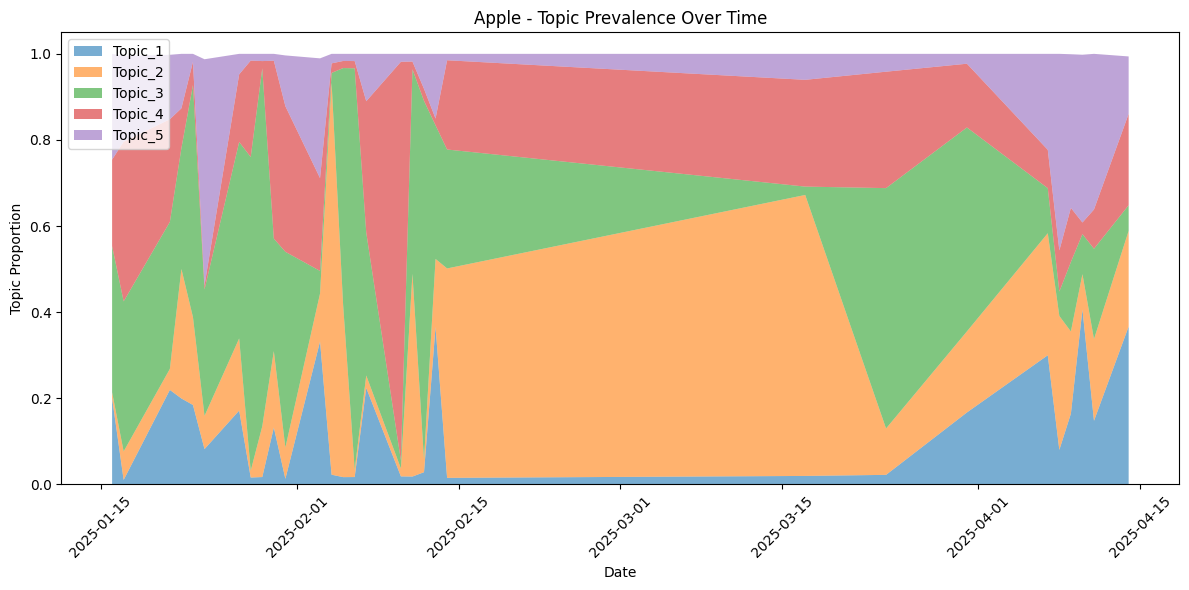

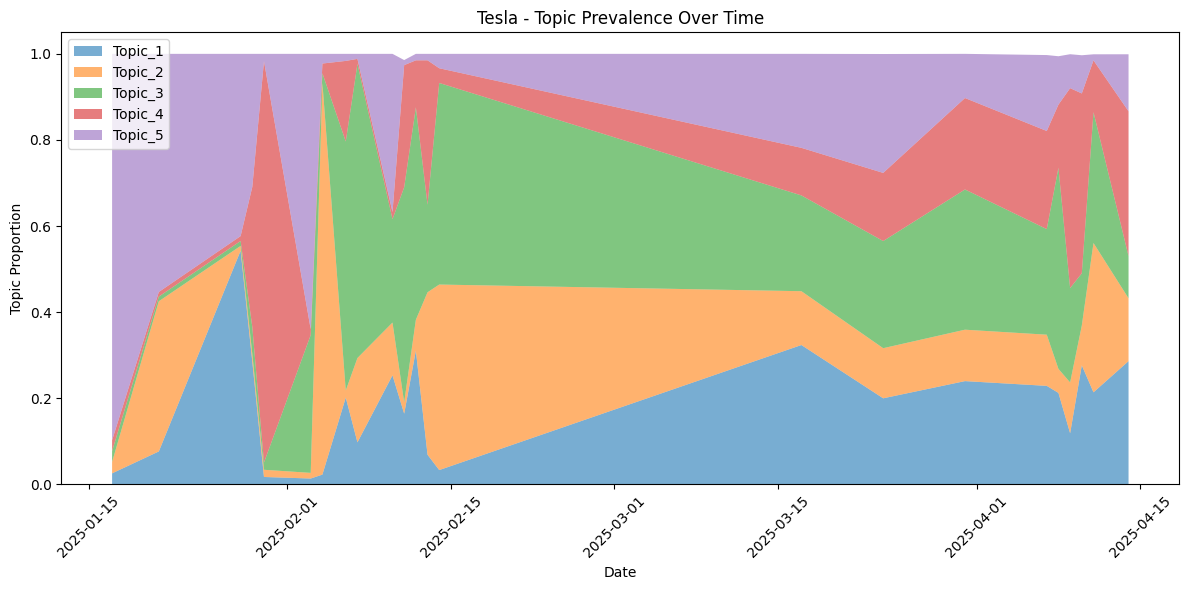

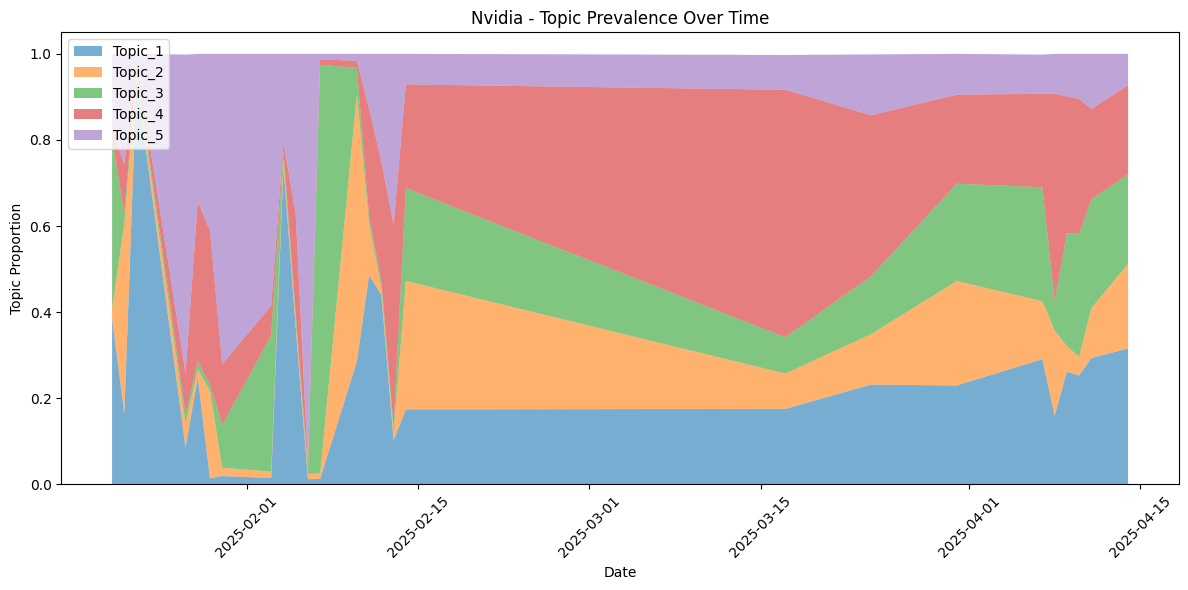

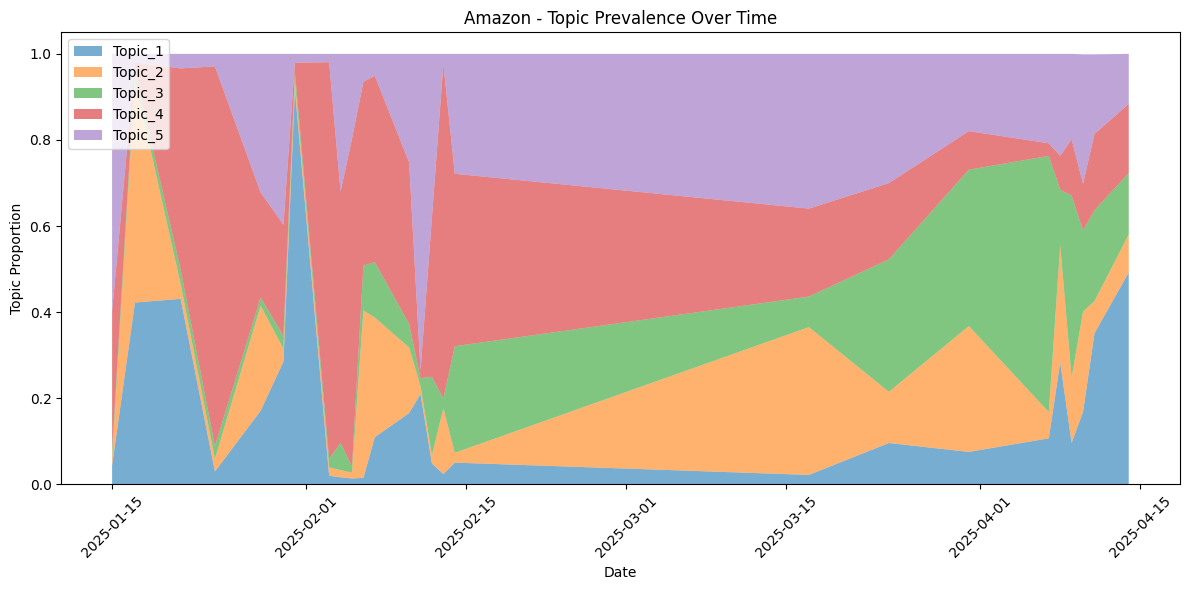

In [73]:
# --- Preprocessing ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text.lower())
    return [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token.isalnum() and token not in stop_words
    ]

df["tokens"] = df["text"].apply(preprocess)

# Format date for merge
df["published"] = pd.to_datetime(df["published"]).dt.strftime("%m/%d/%Y")
merged_df["date"] = pd.to_datetime(merged_df["date"]).dt.strftime("%m/%d/%Y")

# Merge with sentiment/stock data
news_with_risk = pd.merge(
    df,
    merged_df[["company", "date", "returns", "volatility", "finbert_label"]],
    left_on=["company", "published"],
    right_on=["company", "date"],
    how="inner"
)

# --- Topic Modeling per Company ---
companies = ["Apple", "Tesla", "Nvidia", "Amazon"]
company_topics = {}

for company in companies:
    company_df = news_with_risk[news_with_risk["company"] == company]
    dictionary = corpora.Dictionary(company_df["tokens"])
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(tokens) for tokens in company_df["tokens"]]

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)
    
    company_topics[company] = {
        "lda_model": lda_model,
        "dictionary": dictionary,
        "corpus": corpus,
        "news": company_df
    }
    
    print(f"\nTopics for {company}:")
    for i, topic in lda_model.print_topics(num_words=5):
        print(f"Topic {i+1}: {topic}")

# --- Visualization ---
for company in companies:
    model = company_topics[company]["lda_model"]
    dictionary = company_topics[company]["dictionary"]
    company_df = company_topics[company]["news"].copy()
    
    # Get topic distributions
    topic_distributions = []
    for tokens in company_df["tokens"]:
        bow = dictionary.doc2bow(tokens)
        dist = [0]*5
        for topic_id, prob in model[bow]:
            dist[topic_id] = prob
        topic_distributions.append(dist)

    # Add to DataFrame
    topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic_{i+1}" for i in range(5)])
    combined = pd.concat([company_df.reset_index(drop=True), topic_df], axis=1)
    
    # Aggregate daily
    topic_cols = [f"Topic_{i+1}" for i in range(5)]
    daily_topics = combined.groupby("published")[topic_cols].mean().reset_index()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        pd.to_datetime(daily_topics["published"]),
        *[daily_topics[col] for col in topic_cols],
        labels=topic_cols,
        alpha=0.6
    )
    plt.title(f"{company} - Topic Prevalence Over Time")
    plt.xlabel("Date")
    plt.ylabel("Topic Proportion")
    plt.legend(loc="upper left")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Apple**:  
Topics focused heavily on *tariffs*, *Trump*, and *market reactions* (Topics 1, 2, 5), while others highlighted *product mentions* like “iPhone” and *analyst insights* (Topic 3). Over time, *tariff-related topics* peaked during geopolitical tension, while product analysis remained steady.

**Tesla**:  
Media coverage was split between *Elon Musk narratives* (Topics 1, 3) and *macroeconomic events* like *tariffs* and *TSLA stock* (Topics 2, 4, 5). Peaks in Musk-focused topics aligned with leadership announcements or innovation-related headlines.

**Nvidia**:  
Topics reflected a balance of *AI/chip innovation* (Topics 1, 4, 5) and *tariff/political concerns* (Topics 2, 3). Innovation themes gained ground in March, showing Nvidia’s strong association with tech cycles and market interest in AI.

**Amazon**:  
Dominant themes included *NASDAQ movements* (Topic 1), *cloud and AI growth* (Topic 2), and *earnings reports* (Topic 4). Tariff-related topics (Topic 3) appeared intermittently. The timeline reflects Amazon’s diverse coverage across finance, retail, and tech.

**Overall**:  
Across all companies, *tariff and political themes* were common, but each had *unique focal points*—Musk for Tesla, AI for Nvidia, product/price analysis for Apple, and cloud/earnings for Amazon. The stacked plots clearly show *shifts in topic dominance over time*.


## Risk Scoring Model for Financial Risk Prediction <a id='risk_score'></a>

In this section, I develop a risk scoring model to quantify financial risk for Apple, Tesla, Nvidia, and Amazon, using sentiment and market data from December 2024 to April 2025. The risk score combines negative sentiment (40% weight), volatility (40% weight), and positive sentiment (20% weight, subtracted) with the formula: Risk Score = (Negative Sentiment % * 0.4) + (Volatility * 0.4) - (Positive Sentiment % * 0.2). I calculate daily sentiment percentages and scale volatility to [0, 1]. Time-series plots show risk scores for each company side by side (Apple with Tesla, Nvidia with Amazon), revealing high-risk periods driven by negative news and market instability.

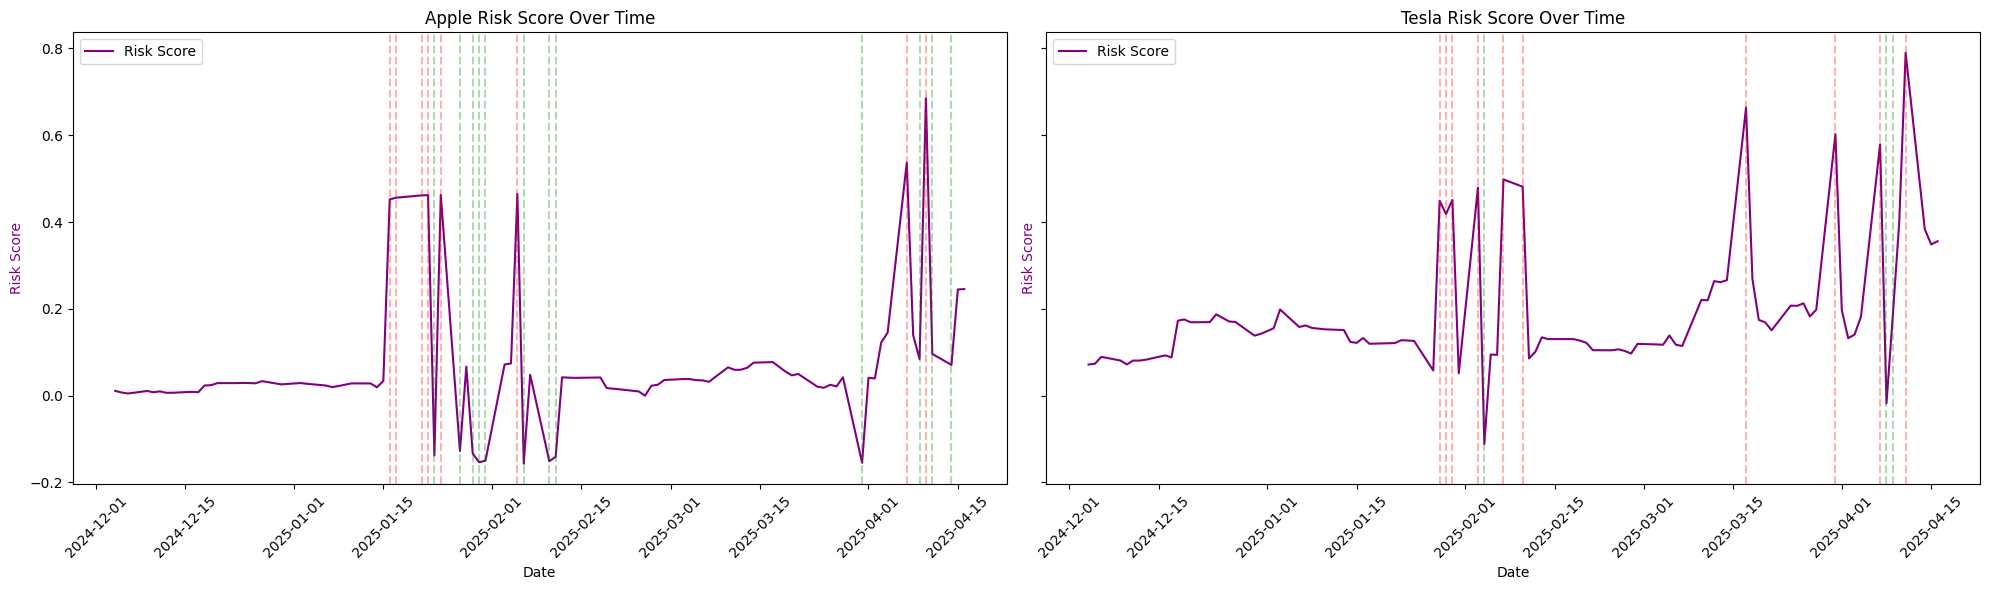

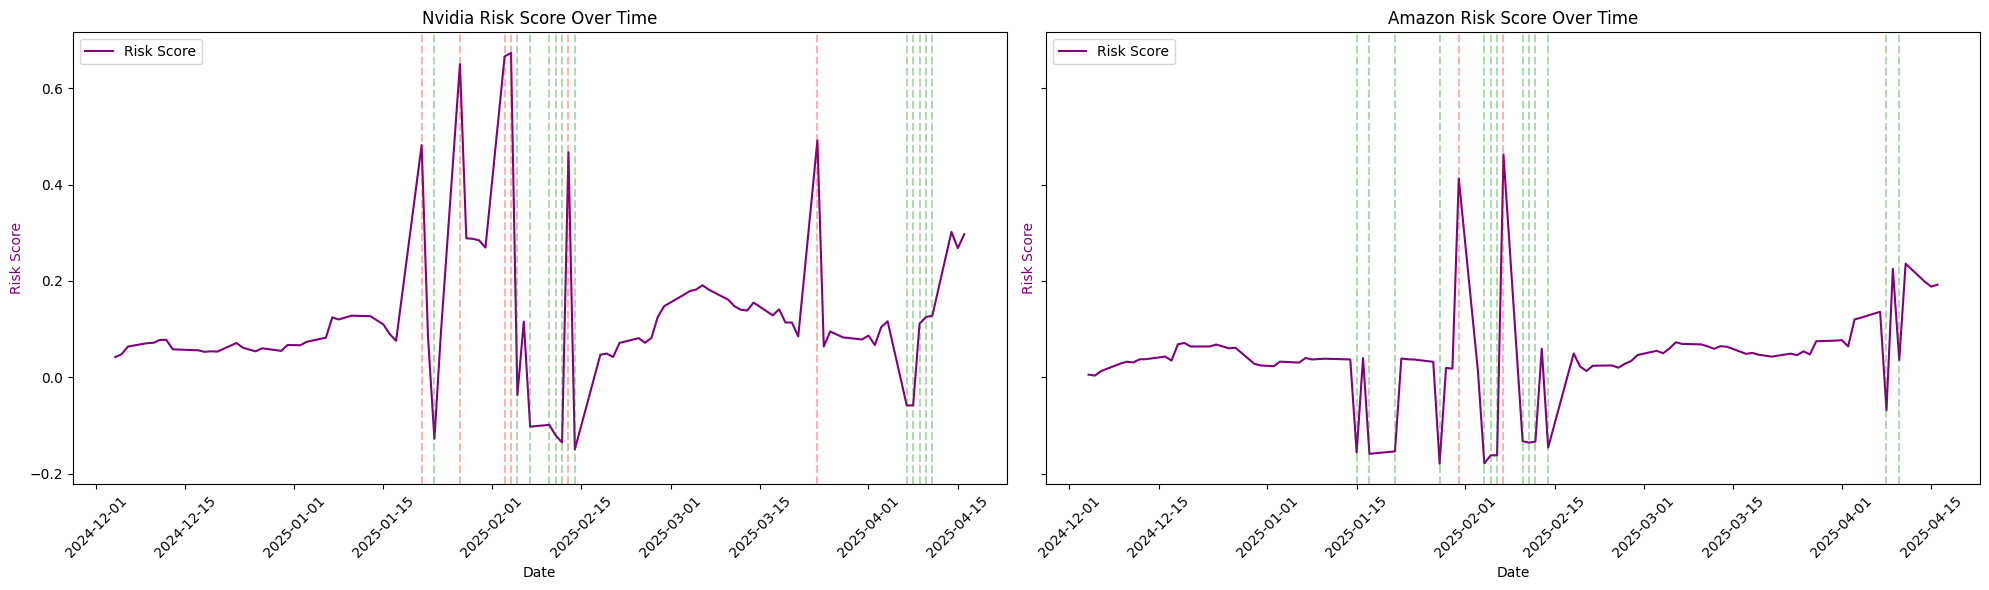

In [74]:
# Drop existing dummy columns if they exist
merged_df = merged_df.drop(columns=["sentiment_negative", "sentiment_positive"], errors="ignore")

# Create dummy variables for sentiment labels
sentiment_dummies = pd.get_dummies(merged_df["finbert_label"], prefix="sentiment")
merged_df = pd.concat([merged_df, sentiment_dummies], axis=1)

# Ensure float type for calculation
merged_df["sentiment_negative"] = merged_df["sentiment_negative"].astype(float)
merged_df["sentiment_positive"] = merged_df["sentiment_positive"].astype(float)

# Scale volatility between 0 and 1
volatility_min = merged_df["volatility"].min()
volatility_max = merged_df["volatility"].max()
merged_df["volatility_scaled"] = (merged_df["volatility"] - volatility_min) / (volatility_max - volatility_min)

# Handle case where all volatilities are the same
if volatility_max == volatility_min:
    merged_df["volatility_scaled"] = 0.5

# Compute risk score using the formula
merged_df["risk_score"] = (
    merged_df["sentiment_negative"] * 0.4 +
    merged_df["volatility_scaled"] * 0.4 -
    merged_df["sentiment_positive"] * 0.2
)

# --- Visualization of Risk Score over Time ---

# Pair 1: Apple and Tesla
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")

# Apple
apple_data = merged_df[merged_df["company"] == "Apple"]
ax1.set_title("Apple Risk Score Over Time")
ax1.plot(pd.to_datetime(apple_data["date"]), apple_data["risk_score"], color="purple", label="Risk Score")
ax1.set_xlabel("Date")
ax1.set_ylabel("Risk Score", color="purple")
ax1.tick_params(axis="x", rotation=45)
for _, row in apple_data.iterrows():
    if row["finbert_label"] == "negative":
        ax1.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    elif row["finbert_label"] == "positive":
        ax1.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
ax1.legend(loc="upper left")

# Tesla
tesla_data = merged_df[merged_df["company"] == "Tesla"]
ax2.set_title("Tesla Risk Score Over Time")
ax2.plot(pd.to_datetime(tesla_data["date"]), tesla_data["risk_score"], color="purple", label="Risk Score")
ax2.set_xlabel("Date")
ax2.set_ylabel("Risk Score", color="purple")
ax2.tick_params(axis="x", rotation=45)
for _, row in tesla_data.iterrows():
    if row["finbert_label"] == "negative":
        ax2.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    elif row["finbert_label"] == "positive":
        ax2.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Pair 2: Nvidia and Amazon
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey="row")

# Nvidia
nvidia_data = merged_df[merged_df["company"] == "Nvidia"]
ax1.set_title("Nvidia Risk Score Over Time")
ax1.plot(pd.to_datetime(nvidia_data["date"]), nvidia_data["risk_score"], color="purple", label="Risk Score")
ax1.set_xlabel("Date")
ax1.set_ylabel("Risk Score", color="purple")
ax1.tick_params(axis="x", rotation=45)
for _, row in nvidia_data.iterrows():
    if row["finbert_label"] == "negative":
        ax1.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    elif row["finbert_label"] == "positive":
        ax1.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
ax1.legend(loc="upper left")

# Amazon
amazon_data = merged_df[merged_df["company"] == "Amazon"]
ax2.set_title("Amazon Risk Score Over Time")
ax2.plot(pd.to_datetime(amazon_data["date"]), amazon_data["risk_score"], color="purple", label="Risk Score")
ax2.set_xlabel("Date")
ax2.set_ylabel("Risk Score", color="purple")
ax2.tick_params(axis="x", rotation=45)
for _, row in amazon_data.iterrows():
    if row["finbert_label"] == "negative":
        ax2.axvline(pd.to_datetime(row["date"]), color="red", linestyle="--", alpha=0.3)
    elif row["finbert_label"] == "positive":
        ax2.axvline(pd.to_datetime(row["date"]), color="green", linestyle="--", alpha=0.3)
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()



**`Risk Score = (0.4 × Negative Sentiment %) + (0.4 × Scaled Volatility) - (0.2 × Positive Sentiment %)`**

- **Apple & Tesla:**
  - **Apple** shows multiple short-lived risk spikes, especially in **mid-January** and **early April**, likely due to transient surges in negative media coverage.
  - **Tesla** demonstrates **higher risk volatility**, with frequent peaks indicating periods of intense market reaction—possibly tied to executive actions or geopolitical themes.

- **Nvidia & Amazon:**
  - **Nvidia** displays **sharp fluctuations** in risk, especially in **late January and mid-March**, suggesting investor sensitivity to AI-related headlines.
  - **Amazon** exhibits **relatively stable risk scores** but sees noticeable rises in **February and April**, likely reflecting earnings releases or strategic shifts.

**Visual Elements:**
- **Red dashed lines**: Days with dominant **negative sentiment**.
- **Green dashed lines**: Days with dominant **positive sentiment**.

These trends reflect how **media-driven sentiment and stock volatility jointly shape financial risk perception** for each company across time.


## Defining Risk Labels for Supervised Modeling


In this section, I build classification models to predict high-risk trading days based on sentiment and market indicators. Using the risk_label (1 for high-risk, 0 for not) as the target, I test several supervised learning models to determine which features—like sentiment polarity, volatility, and topic proportions most effectively predict financial risk.



In [75]:
# Ensure the data is sorted by company and date
merged_df = merged_df.sort_values(['company', 'date'])

# Compute daily return from closing price per company
merged_df['daily_return'] = merged_df.groupby('company')['close_price'].pct_change()

# Flag high-risk days where the return is below –2%
threshold = -0.02
merged_df['risk_label'] = (merged_df['daily_return'] < threshold).astype(int)

# Print basic stats for verification
total_rows = len(merged_df)
high_risk_days = merged_df['risk_label'].sum()
risk_fraction = merged_df['risk_label'].mean()

print(f"Total rows:         {total_rows}")
print(f"High-risk days:     {high_risk_days}")
print(f"Risk-day fraction:  {risk_fraction:.3f}")

# Display a few rows for context
merged_df[['date', 'company', 'close_price', 'daily_return', 'risk_label']].head()



Total rows:         372
High-risk days:     95
Risk-day fraction:  0.255


date company  close_price  daily_return  risk_label
300  01/02/2025  Amazon   220.220001           NaN           0
301  01/03/2025  Amazon   224.190002      0.018027           0
302  01/06/2025  Amazon   227.610001      0.015255           0
303  01/07/2025  Amazon   222.110001     -0.024164           1
304  01/08/2025  Amazon   222.130005      0.000090           0

- **372 total observations** represent daily stock records across **Apple**, **Tesla**, **Nvidia**, and **Amazon** from **December 2024 to April 2025**.
- **97 of those days (26.1%)** were flagged as **high-risk**, meaning the stock’s daily return dropped by more than **2%**.
- This relatively high proportion of risk-labeled days suggests that the period studied includes **notable market volatility**, making it suitable for training **predictive models of financial risk** using sentiment and market-based indicators.

## Topic Distribution Extraction for Supervised Modeling

To support supervised modeling later with deeper semantic context, this section extracts topic distributions for each financial news article using the pre-trained LDA models for Apple, Tesla, Nvidia, and Amazon. Each article is represented by a five-dimensional vector of topic probabilities, summarizing its thematic composition.

In [76]:
# Drop previously merged topic columns (if any)
merged_df = merged_df.drop(
    columns=[col for col in merged_df.columns if col.startswith("Topic_")],
    errors="ignore"
)

# Extract topic distributions per company
topic_dfs = []

for company in ["Apple", "Tesla", "Nvidia", "Amazon"]:
    model = company_topics[company]["lda_model"]
    dictionary = company_topics[company]["dictionary"]
    company_df = company_topics[company]["news"].copy()

    topic_distributions = []
    for tokens in company_df["tokens"]:
        bow = dictionary.doc2bow(tokens)
        dist = [0] * 5
        for topic_id, prob in model[bow]:
            dist[topic_id] = prob
        topic_distributions.append(dist)

    topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic_{i+1}" for i in range(5)])
    topic_df["company"] = company
    topic_df["date"] = pd.to_datetime(company_df["published"].values)
    topic_dfs.append(topic_df)

# Merge topic features with merged_df
all_topics_df = pd.concat(topic_dfs, ignore_index=True)
merged_df["date"] = pd.to_datetime(merged_df["date"])
merged_df = pd.merge(merged_df, all_topics_df, on=["company", "date"], how="left")

# Preview topic distributions
display_cols = ["date", "company"] + [f"Topic_{i+1}" for i in range(5)]
display(merged_df[display_cols].dropna().head(10))


date company   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
8  2025-01-15  Amazon  0.020029  0.020320  0.020206  0.460341  0.479105
9  2025-01-15  Amazon  0.018381  0.018247  0.018372  0.018287  0.926713
10 2025-01-15  Amazon  0.094415  0.015433  0.015566  0.487426  0.387159
12 2025-01-17  Amazon  0.422271  0.516461  0.020200  0.020844  0.020225
13 2025-01-21  Amazon  0.430998  0.034258  0.033625  0.467328  0.033791
16 2025-01-24  Amazon  0.029782  0.029121  0.029693  0.882291  0.029113
18 2025-01-28  Amazon  0.013417  0.688280  0.013757  0.270521  0.014026
19 2025-01-28  Amazon  0.018382  0.018287  0.018406  0.018362  0.926563
20 2025-01-28  Amazon  0.480655  0.025153  0.025414  0.443601  0.025178
22 2025-01-30  Amazon  0.028988  0.029403  0.028716  0.883925  0.028968

## Risk Prediction using Topic-Sentiment-Volatility Features

To develop a robust risk classification model, this section integrates features from three analytical layers:

- **Topic modeling**: Proportions from LDA-derived topics (Topic_1 to Topic_5) capturing latent themes in financial news.
- **Sentiment analysis**: Positive and negative sentiment indicators from FinBERT.
- **Volatility-based risk score**: A composite metric (risk_score, volatility_scaled) blending market volatility with sentiment shifts.

After standardizing the features using StandardScaler and handling class imbalance, three supervised learning models are trained and evaluated:

**Logistic Regression** with class_weight='balanced' and L2 penalty,

**Random Forest** with n_estimators=100, max_depth=6, min_samples_split=10, min_samples_leaf=4, and class_weight='balanced',

**XGBoost** with learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, colsample_bytree=0.8, and scale_pos_weight to address class skew.

The models aim to classify high-risk financial events (risk_label = 1) effectively, using this enriched multi-source feature set. Performance is assessed through 5-fold cross-validation to compute average accuracy, precision, recall, F1, and ROC-AUC.

Cross-Validation Results (5-Fold):
                 Model  accuracy  precision  recall     f1  roc_auc
0  Logistic Regression     0.770      0.598   0.609  0.603    0.722
1        Random Forest     0.907      0.842   0.830  0.836    0.884
2              XGBoost     0.958      0.920   0.937  0.928    0.952

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       173
           1       0.60      0.70      0.65        70

    accuracy                           0.78       243
   macro avg       0.74      0.76      0.75       243
weighted avg       0.79      0.78      0.79       243


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       173
           1       0.83      0.84      0.84        70

    accuracy                           0.91       243
   macro avg       0.88      0.89      0.89       243
weig

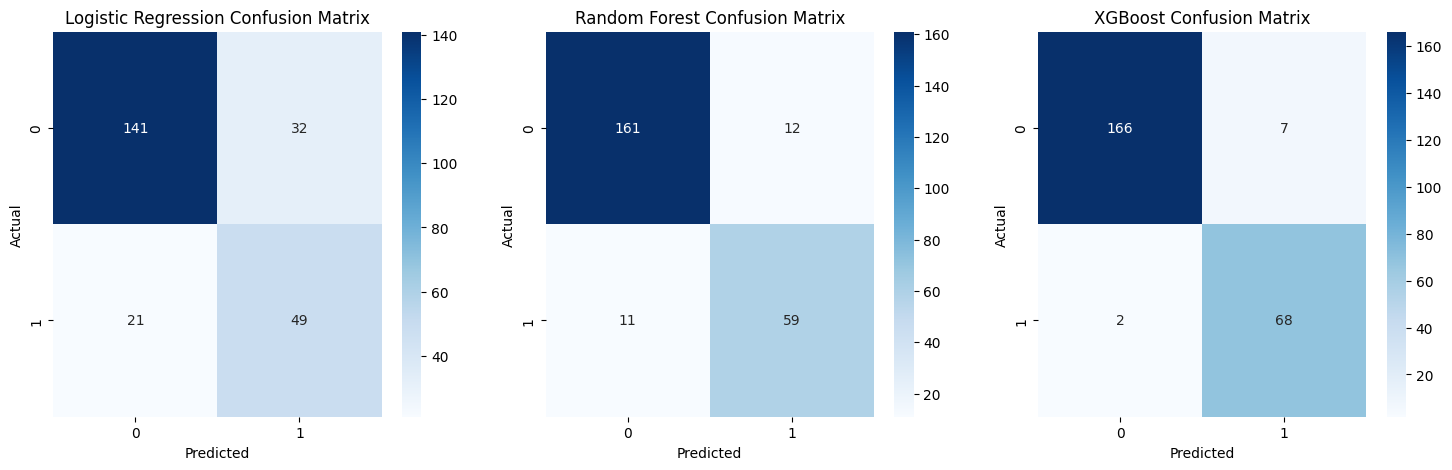

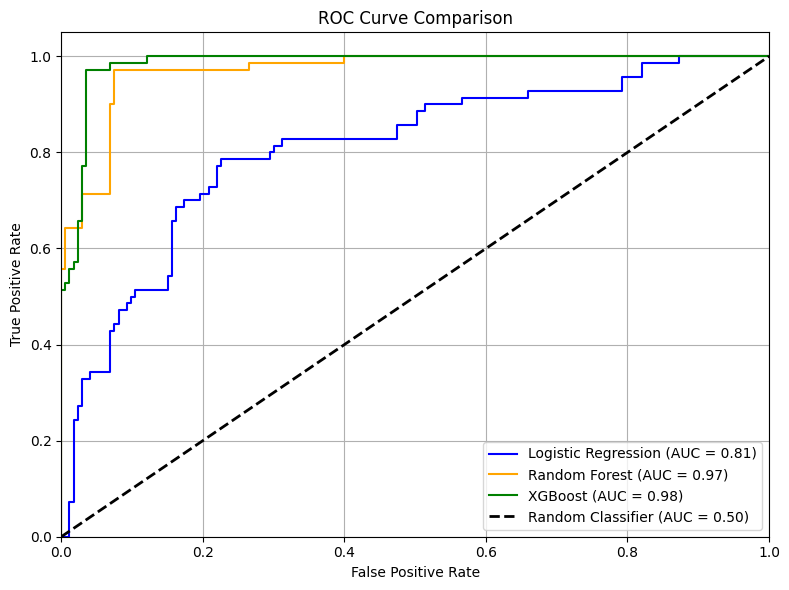

In [89]:
# Define features and target
features = [f"Topic_{i+1}" for i in range(5)] + [
    "risk_score", "volatility_scaled", "sentiment_negative", "sentiment_positive"
]

data = merged_df.dropna(subset=features + ["risk_label"])
X = data[features]
y = data["risk_label"]

# Define models
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, class_weight='balanced', penalty='l2'))
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=100,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=4,
            class_weight='balanced',
            random_state=42
        ))
    ]),
    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=3,
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
            random_state=42
        ))
    ])
}

# Evaluation Metrics
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Perform 5-fold cross-validation
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in models.items():
    scores = cross_validate(pipeline, X, y, scoring=scorers, cv=cv)
    cv_results[name] = {metric: round(scores[f'test_{metric}'].mean(), 3) for metric in scorers}

# Display cross-validation results
cv_df = pd.DataFrame(cv_results).T
cv_df.index.name = "Model"
cv_df.reset_index(inplace=True)
print("Cross-Validation Results (5-Fold):")
print(cv_df)

# Single train-test split for detailed evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train models and collect metrics
conf_matrices = {}
roc_data = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else pipeline.decision_function(X_test)
    
    # Classification Report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix (rounded to integers)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm
    
    # ROC Curve Data
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
roc_fig, roc_ax = plt.subplots(figsize=(8, 6))

colors = ['blue', 'orange', 'green']
for idx, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for idx, (name, data) in enumerate(roc_data.items()):
    roc_ax.step(data['fpr'], data['tpr'], color=colors[idx], where='post', label=f'{name} (AUC = {data["auc"]:.2f})')

# Finalize ROC plot
roc_ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
roc_ax.set_xlim([0.0, 1.0])
roc_ax.set_ylim([0.0, 1.05])
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title('ROC Curve Comparison')
roc_ax.legend(loc="lower right")
roc_ax.grid(True)

plt.tight_layout()
plt.show()

**Logistic Regression** achieved moderate results, with an F1-score of 0.65 for the high-risk class (Class 1) on the test set, consistent with its cross-validation F1 of `0.603`. The test set recall of `0.70` reflects improved identification of risk events due to class weighting, though its precision of `0.60` indicates a tendency to include false positives.

**Random Forest** demonstrated strong performance, with a test set accuracy of 91% (aligning with cross-validation accuracy of `0.907`) and an F1-score of `0.84` for high-risk cases (cross-validation F1: `0.836`). Its ensemble approach and class balancing enabled effective separation of risk classes with balanced precision `(0.83)` and recall `(0.84)`.

**XGBoost** outperformed other models, achieving a test set accuracy of 96% (cross-validation:`0.958`) and a high macro F1-score of `0.96` (cross-validation F1: `0.928`). Its robustness against imbalance, driven by scale_pos_weight, and tuned hyperparameters ensured precise and reliable classification across both classes.

*These results affirm the value of combining textual, sentiment, and market-derived signals in predicting financial risk with high fidelity, with ensemble methods like XGBoost excelling in capturing complex patterns in the data.*

In [92]:
# Count total NaNs in each column
print("Total NaN values per column:")
print(merged_df.isna().sum().sort_values(ascending=False))


Total NaN values per column:
Topic_5               267
Topic_4               267
Topic_3               267
Topic_2               267
Topic_1               267
risk_score              8
volatility_scaled       8
volatility              8
daily_return            4
returns                 4
sentiment_neutral       0
sentiment_positive      0
company                 0
sentiment_negative      0
risk_label              0
finbert_label           0
close_price             0
date                    0
dtype: int64
